In [1]:
from scipy.integrate import odeint
from scipy.optimize import minimize_scalar,minimize
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import pandas as pd
from scipy import stats
from multiprocessing import Process,Queue,Pool
import matplotlib
matplotlib.rcParams['figure.dpi'] = 500
import pickle as pkl
import importlib
from matplotlib.backends.backend_pdf import PdfPages
import sys
sys.path.append("../src/")
from flux_finding_mp import *
rd.seed(1000)
np.random.seed(1000)
from functools import partial
import seaborn as sb
from sklearn.metrics import r2_score

In [2]:
numCores = 20
numBestFitIters = 5
numSims = 100
ts = np.linspace(0,30,100)

In [3]:
data,lacE,glycolysis,fluxes,conc,c0s,vhvds = generateSyntheticData(ts)
print(conc)
print(vhvds)
conc = {key:val for key,val in conc.items() if key != "NADH"}
data

{'Lactate': 0.9526443992215418, 'G3P': 0.9311434346775108, 'Malate': 0.41543095304490785, 'NADH': 0.02898165938687125}
{'vhvd_nadh_ldh': 1.0, 'vhvd_nadh_mas': 1.0, 'vhvd_gap_gapdh': 1.0, 'vhvd_nadh_g3ps': 1.0, 'vhvd_dhap_g3ps': 1.0, 'vhvd_nadh_dhap_g3ps': 1.0}


,UL_lac,UL_g3p,UL_malate,UL_nadh,UL_gap,L_lac,L_malate,L_nadh,L_gap,L_g3p_M+1,L_g3p_M+2
0,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.998981,0.999463,0.996945,0.983733,0.972019,0.001019,0.003055,0.016267,0.027981,0.000533,0.000004
2,0.996213,0.997915,0.989635,0.966999,0.945754,0.003787,0.010365,0.033001,0.054246,0.002056,0.000029
3,0.992135,0.995456,0.980121,0.951290,0.921098,0.007865,0.019879,0.048710,0.078902,0.004449,0.000095
4,0.987166,0.992197,0.969739,0.936545,0.897954,0.012834,0.030261,0.063455,0.102046,0.007588,0.000215
...,...,...,...,...,...,...,...,...,...,...,...
95,0.849103,0.605537,0.782861,0.711447,0.544647,0.150897,0.217139,0.288553,0.455353,0.312621,0.081842
96,0.849073,0.604545,0.782824,0.711403,0.544578,0.150927,0.217176,0.288597,0.455422,0.313303,0.082152
97,0.849044,0.603586,0.782789,0.711362,0.544514,0.150956,0.217211,0.288638,0.455486,0.313962,0.082452
98,0.849018,0.602659,0.782757,0.711324,0.544453,0.150982,0.217243,0.288676,0.455547,0.314598,0.082743


[0.91073217 0.44863288 0.32849674 0.57803612]
-1 1.8225651995238434
[0.42886097 0.07546324 0.62353997 0.71472647]
{'Lactate': 0.9526443992215418, 'G3P': 0.9311434346775108, 'Malate': 0.41543095304490785}


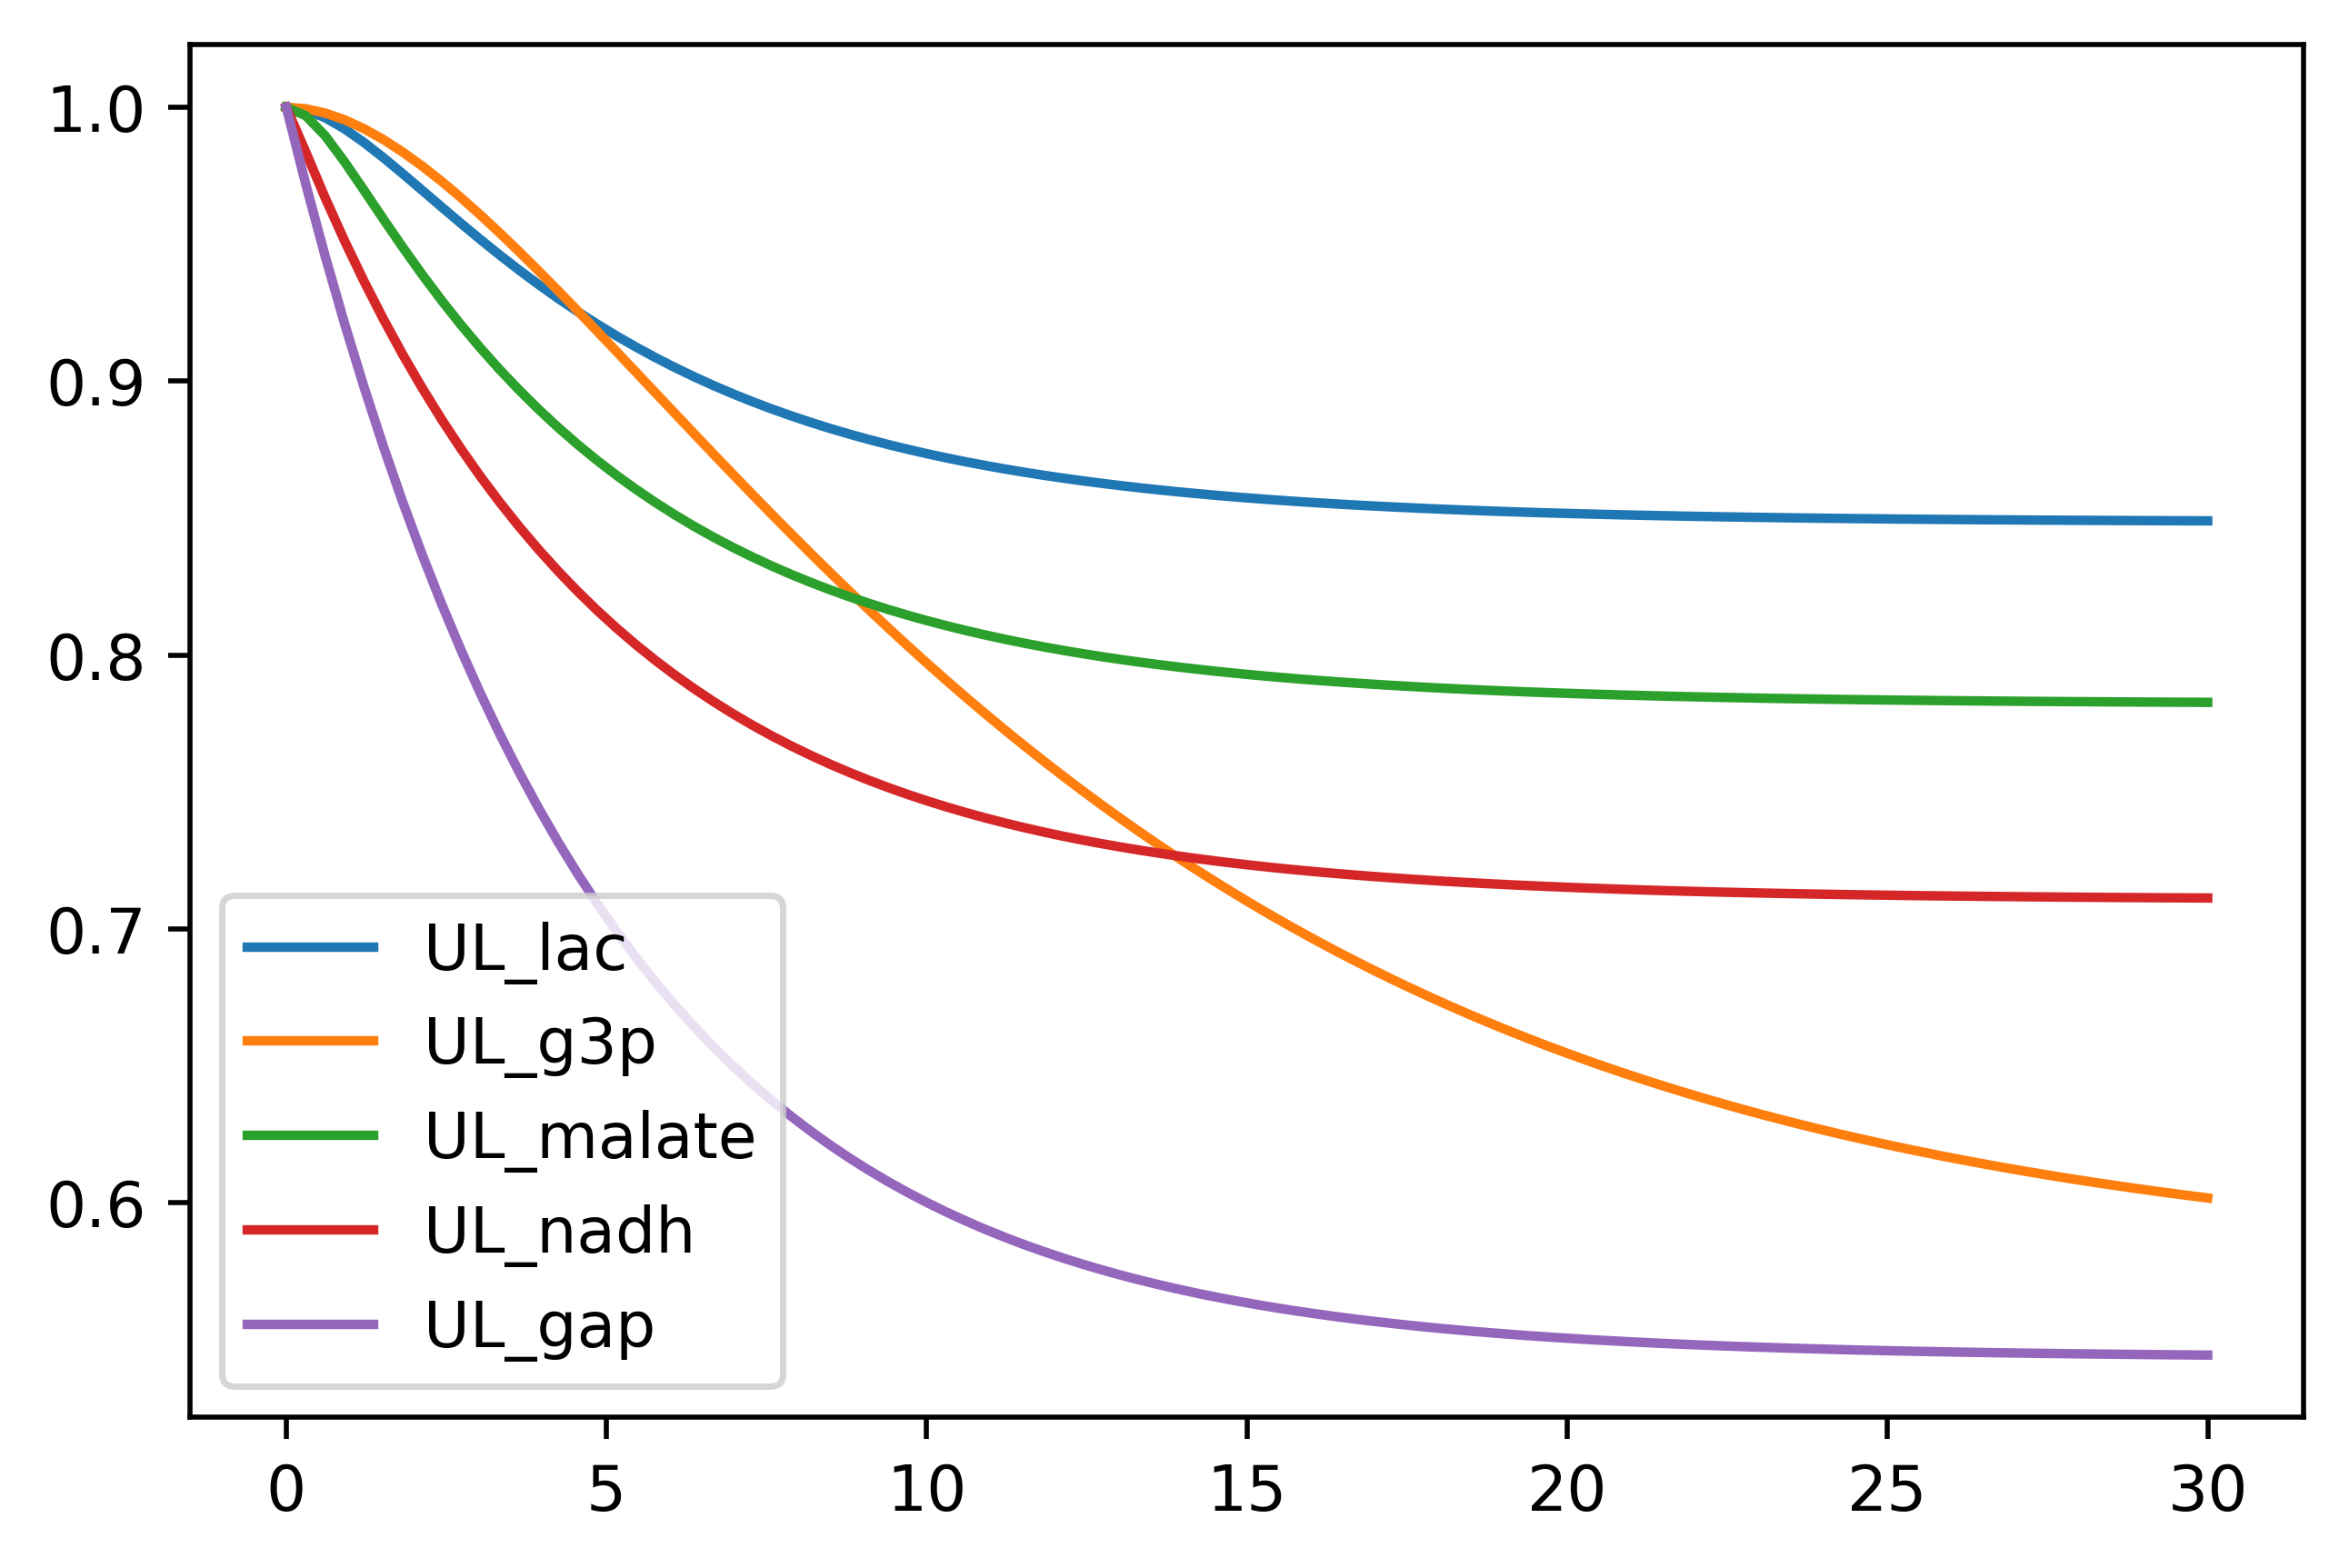

In [4]:
for col in ["UL_lac","UL_g3p","UL_malate","UL_nadh","UL_gap"]:
    plt.plot(ts,data[col],label=col)
plt.legend()
print(c0s)
print(lacE,glycolysis)
print(fluxes)
print(conc)

In [7]:
fluxes_inferred,C0s_inferred,df,conc,error = findFlux(data, ts, conc, lacE, glycolysis,vhvds, np.array([0,0,0,0]))
print(fluxes_inferred)
print(C0s_inferred)
print(conc)
print(error)
df

{'vhvd_nadh_ldh': 1.0, 'vhvd_nadh_mas': 1.0, 'vhvd_gap_gapdh': 1.0, 'vhvd_nadh_g3ps': 1.0, 'vhvd_dhap_g3ps': 1.0, 'vhvd_nadh_dhap_g3ps': 1.0}
[4.6428125  0.04000391 6.7438125  0.218     ]
[-0.822681   -0.85315308 -0.87680935 16.02570506]
{'Lactate': 0.9526443992215418, 'G3P': 0.9311434346775108, 'Malate': 0.41543095304490785, 'NADH': 0.0946289062499992}
[2.30660776e-08 4.74557323e-04 1.35813341e-08 9.29090393e-14]


,UL_lac,UL_g3p,UL_malate,UL_nadh,UL_gap,L_lac,L_malate,L_nadh,L_gap,L_g3p_M+1,L_g3p_M+2,L_g3p
0,1.000000,1.000000,1.000000,4.071562,1.000000,0.000000,0.000000,-3.071562,0.000000,0.000000,0.000000,0.000000
1,2.907450,1.019588,6.093959,0.998515,0.972019,-1.907450,-5.093959,0.001485,0.027981,0.000533,0.000004,-0.019588
2,2.464994,1.018986,3.770238,0.996942,0.945754,-1.464994,-2.770238,0.003058,0.054246,0.002056,0.000029,-0.018986
3,2.122511,1.018036,2.497013,0.995486,0.921098,-1.122511,-1.497013,0.004514,0.078902,0.004449,0.000095,-0.018036
4,1.857103,1.016762,1.797239,0.994119,0.897954,-0.857103,-0.797239,0.005881,0.102046,0.007588,0.000215,-0.016762
...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.849291,0.565825,0.782964,0.973255,0.544647,0.150709,0.217036,0.026745,0.455353,0.312621,0.081842,0.434175
96,0.849261,0.560542,0.782927,0.973251,0.544578,0.150739,0.217073,0.026749,0.455422,0.313303,0.082152,0.439458
97,0.849233,0.555268,0.782892,0.973248,0.544514,0.150767,0.217108,0.026752,0.455486,0.313962,0.082452,0.444732
98,0.849206,0.550004,0.782860,0.973244,0.544453,0.150794,0.217140,0.026756,0.455547,0.314598,0.082743,0.449996


In [8]:
dhap_params = fitSource(ts, data["UL_gap"])
dhap = lambda x: exponetialCurve(x,dhap_params)

    
firstT = np.min(ts)
firstT = [x for x in range(len(ts)) if abs(firstT-ts[x]) < 1e-5]
initialState = [np.mean(data.loc[firstT,label])*c for label,c in zip(["UL_lac","UL_g3p","UL_malate","UL_nadh"],[conc["Lactate"],conc["G3P"],conc["Malate"],conc["NADH"]])]


nadh = interp1d(ts,
                integrateModel(nadhEquation,ts,(fluxes_inferred[3],conc['NADH'],C0s_inferred[3] * fluxes_inferred[3],None,dhap,vhvds),initialState[3],conc["NADH"])[:,0],
                bounds_error=False,fill_value="extrapolate") 


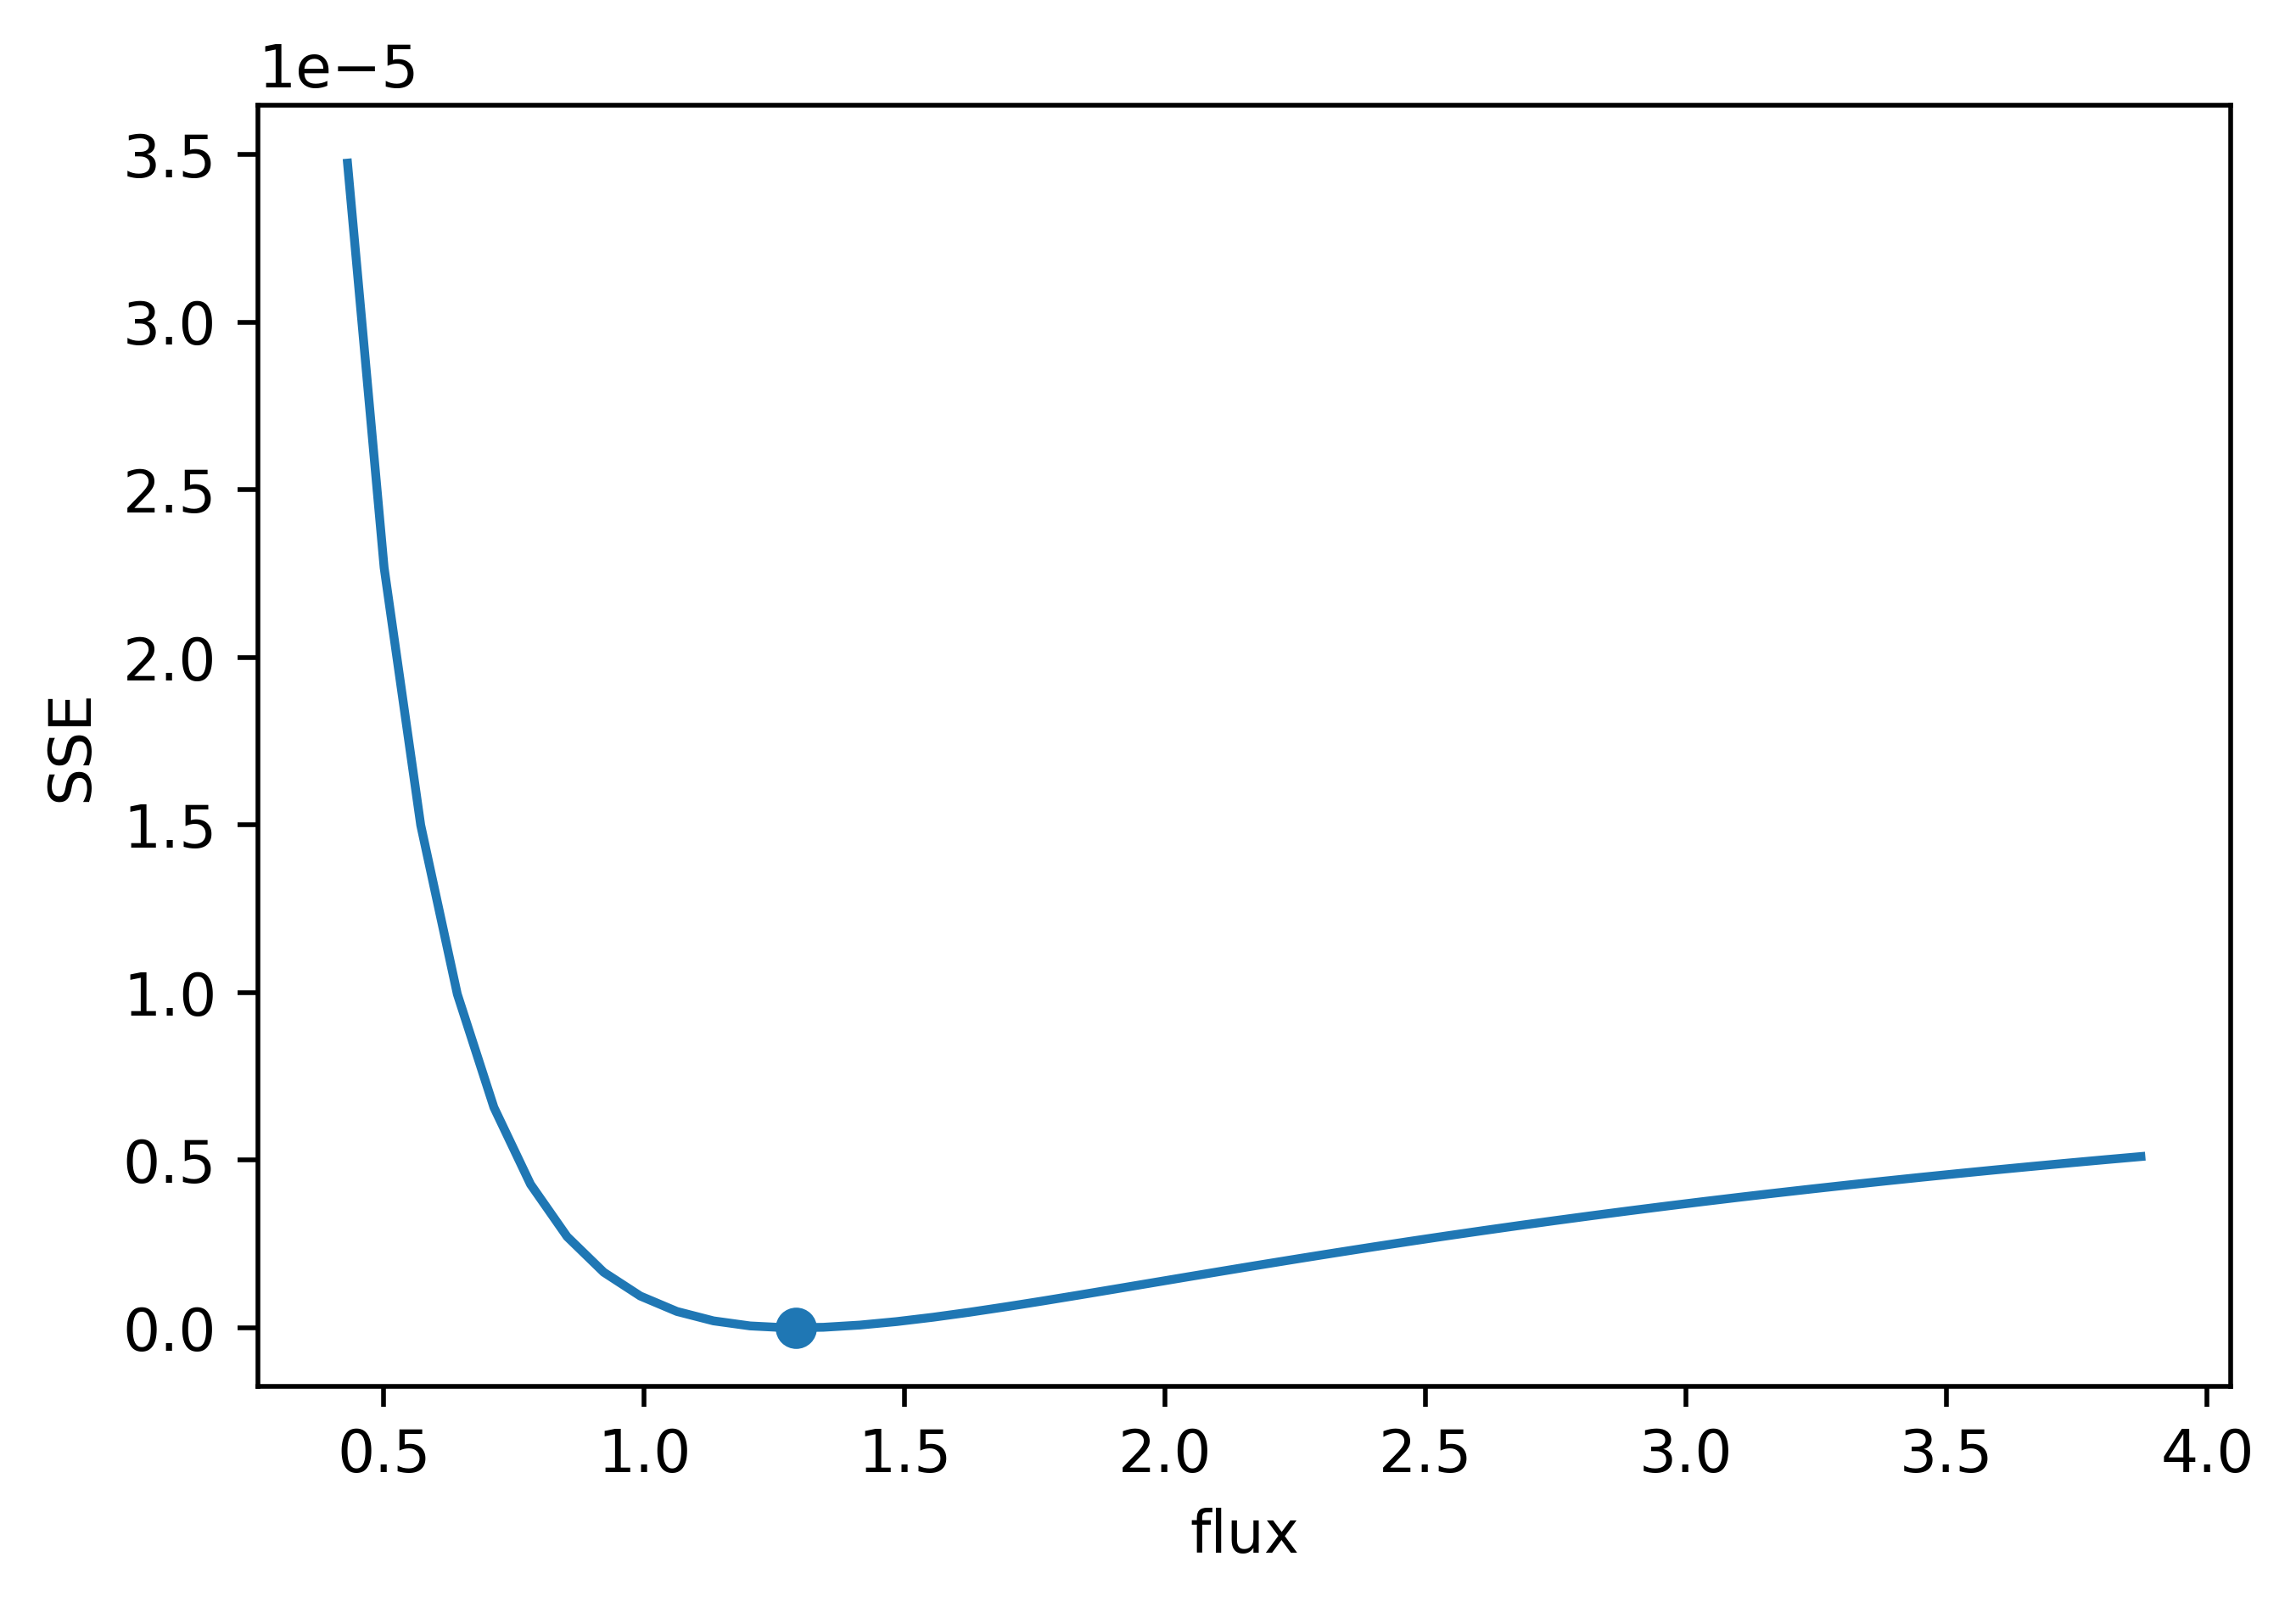

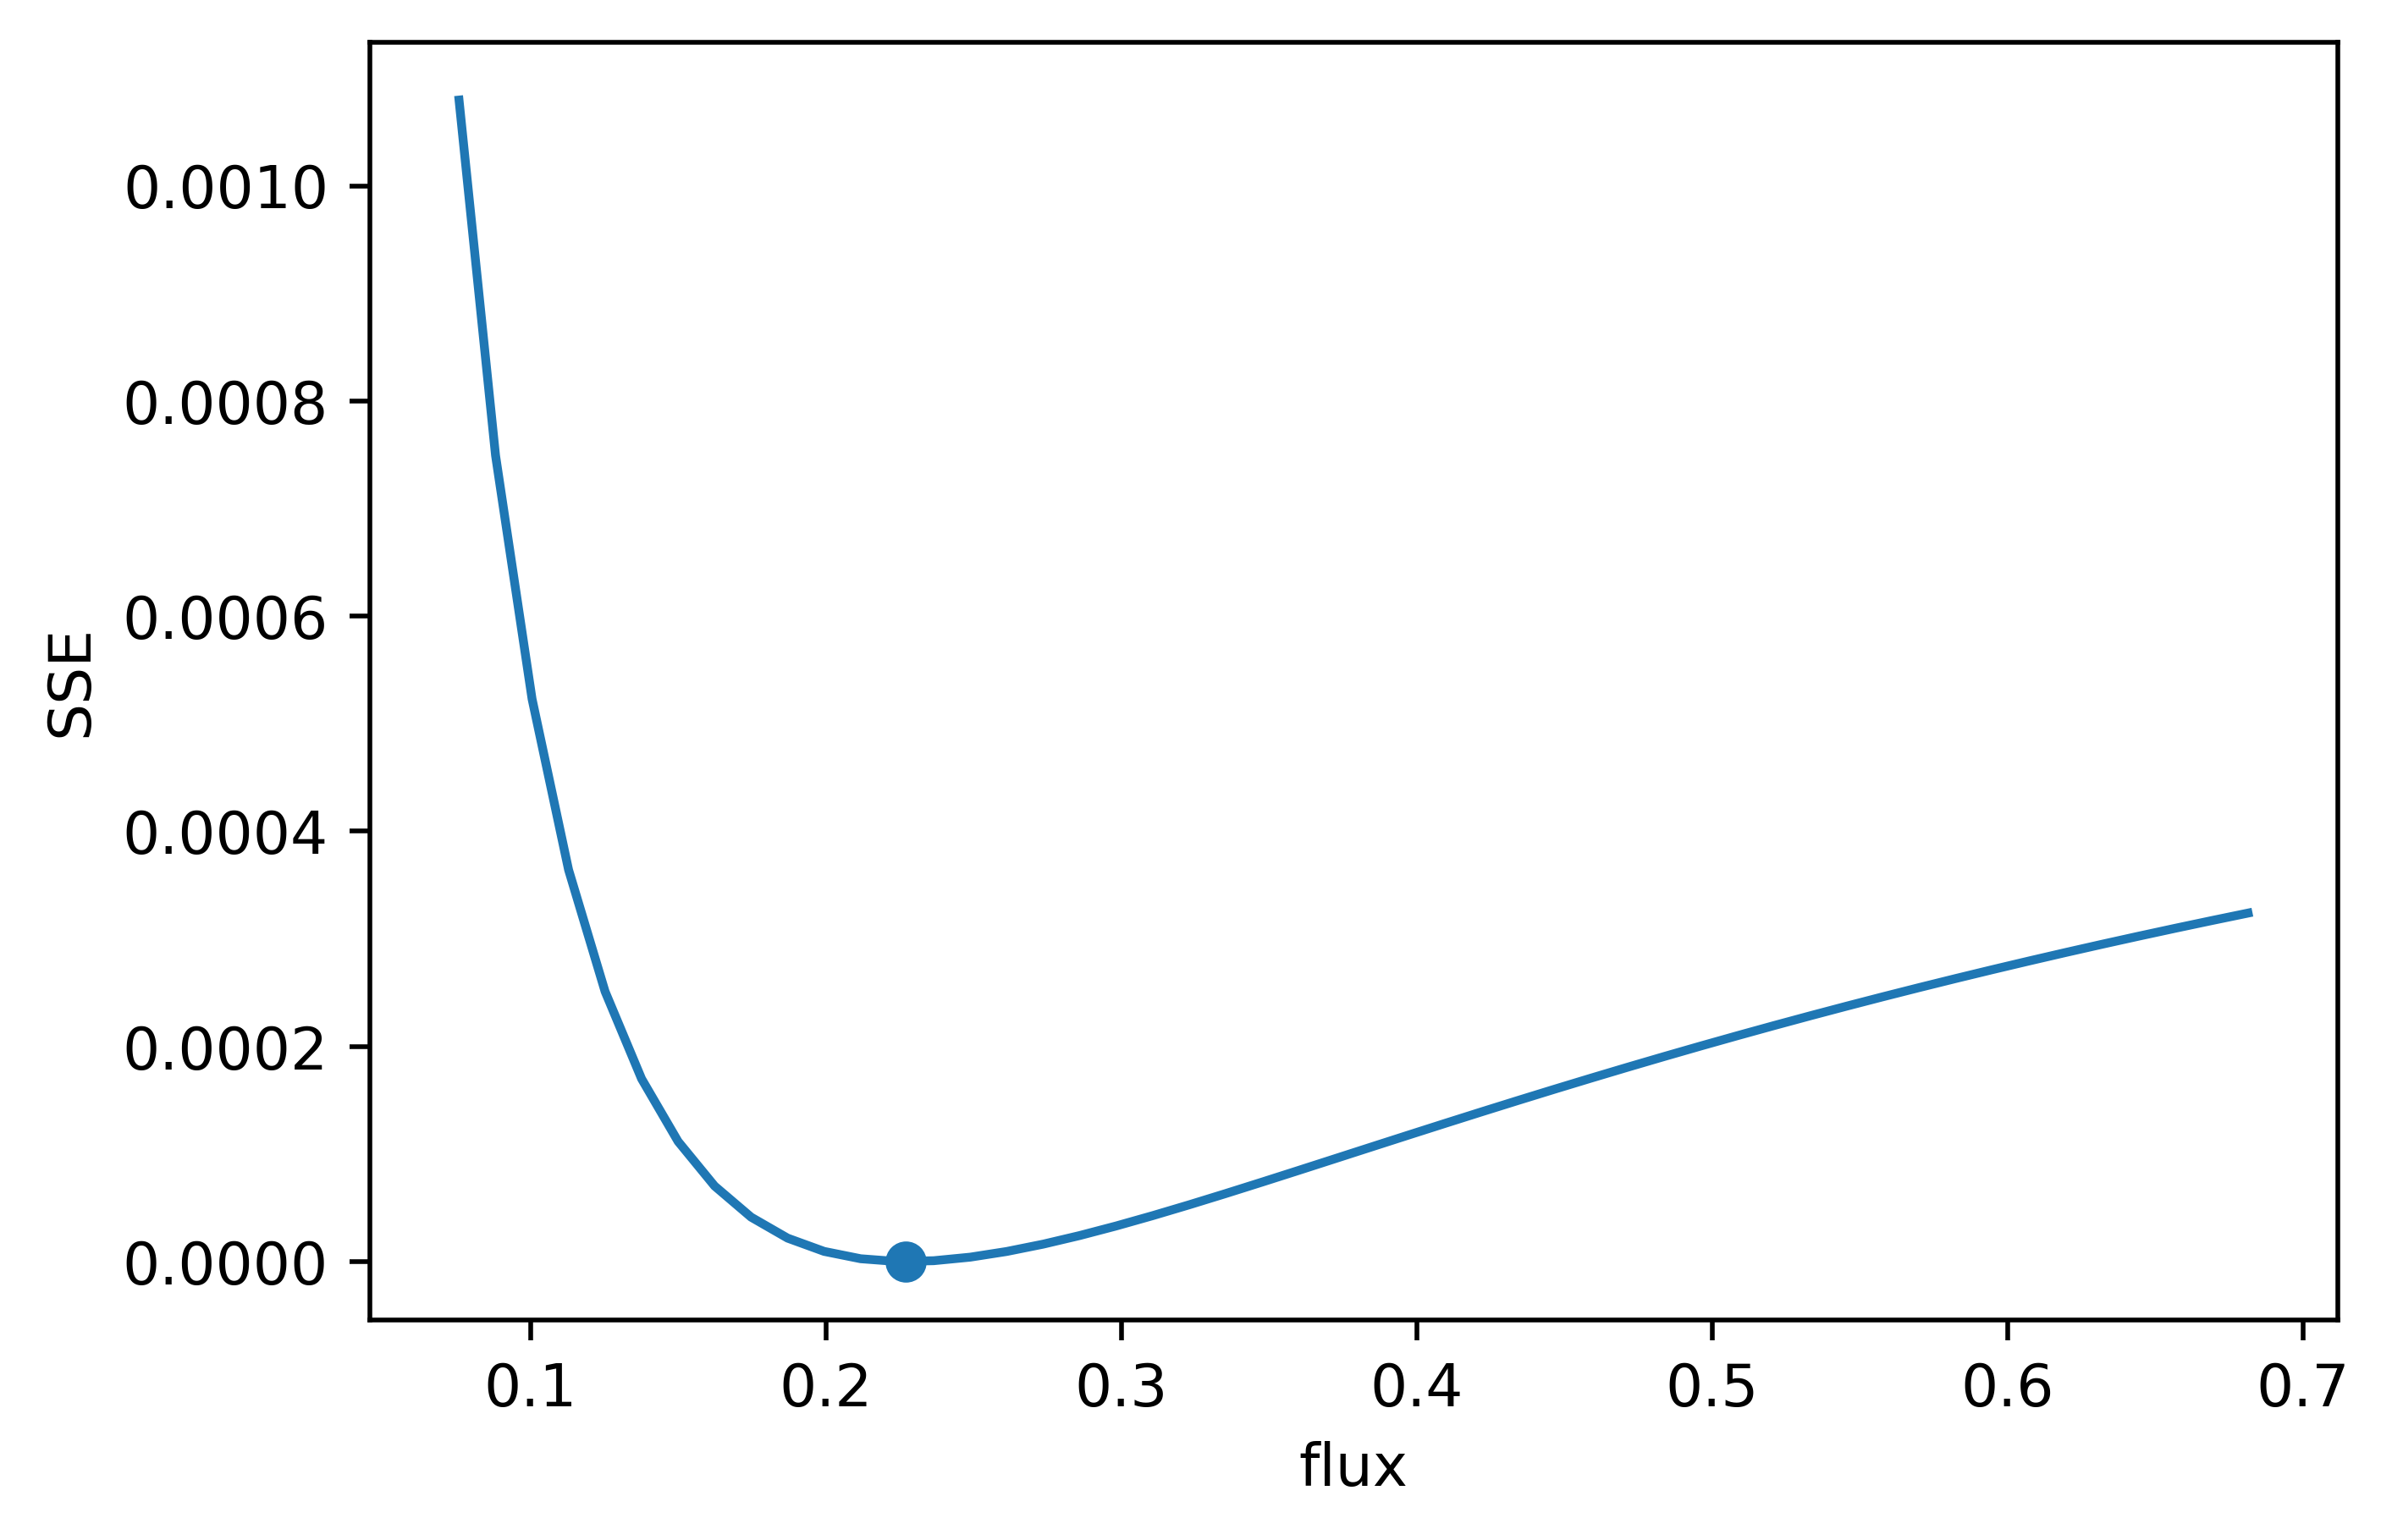

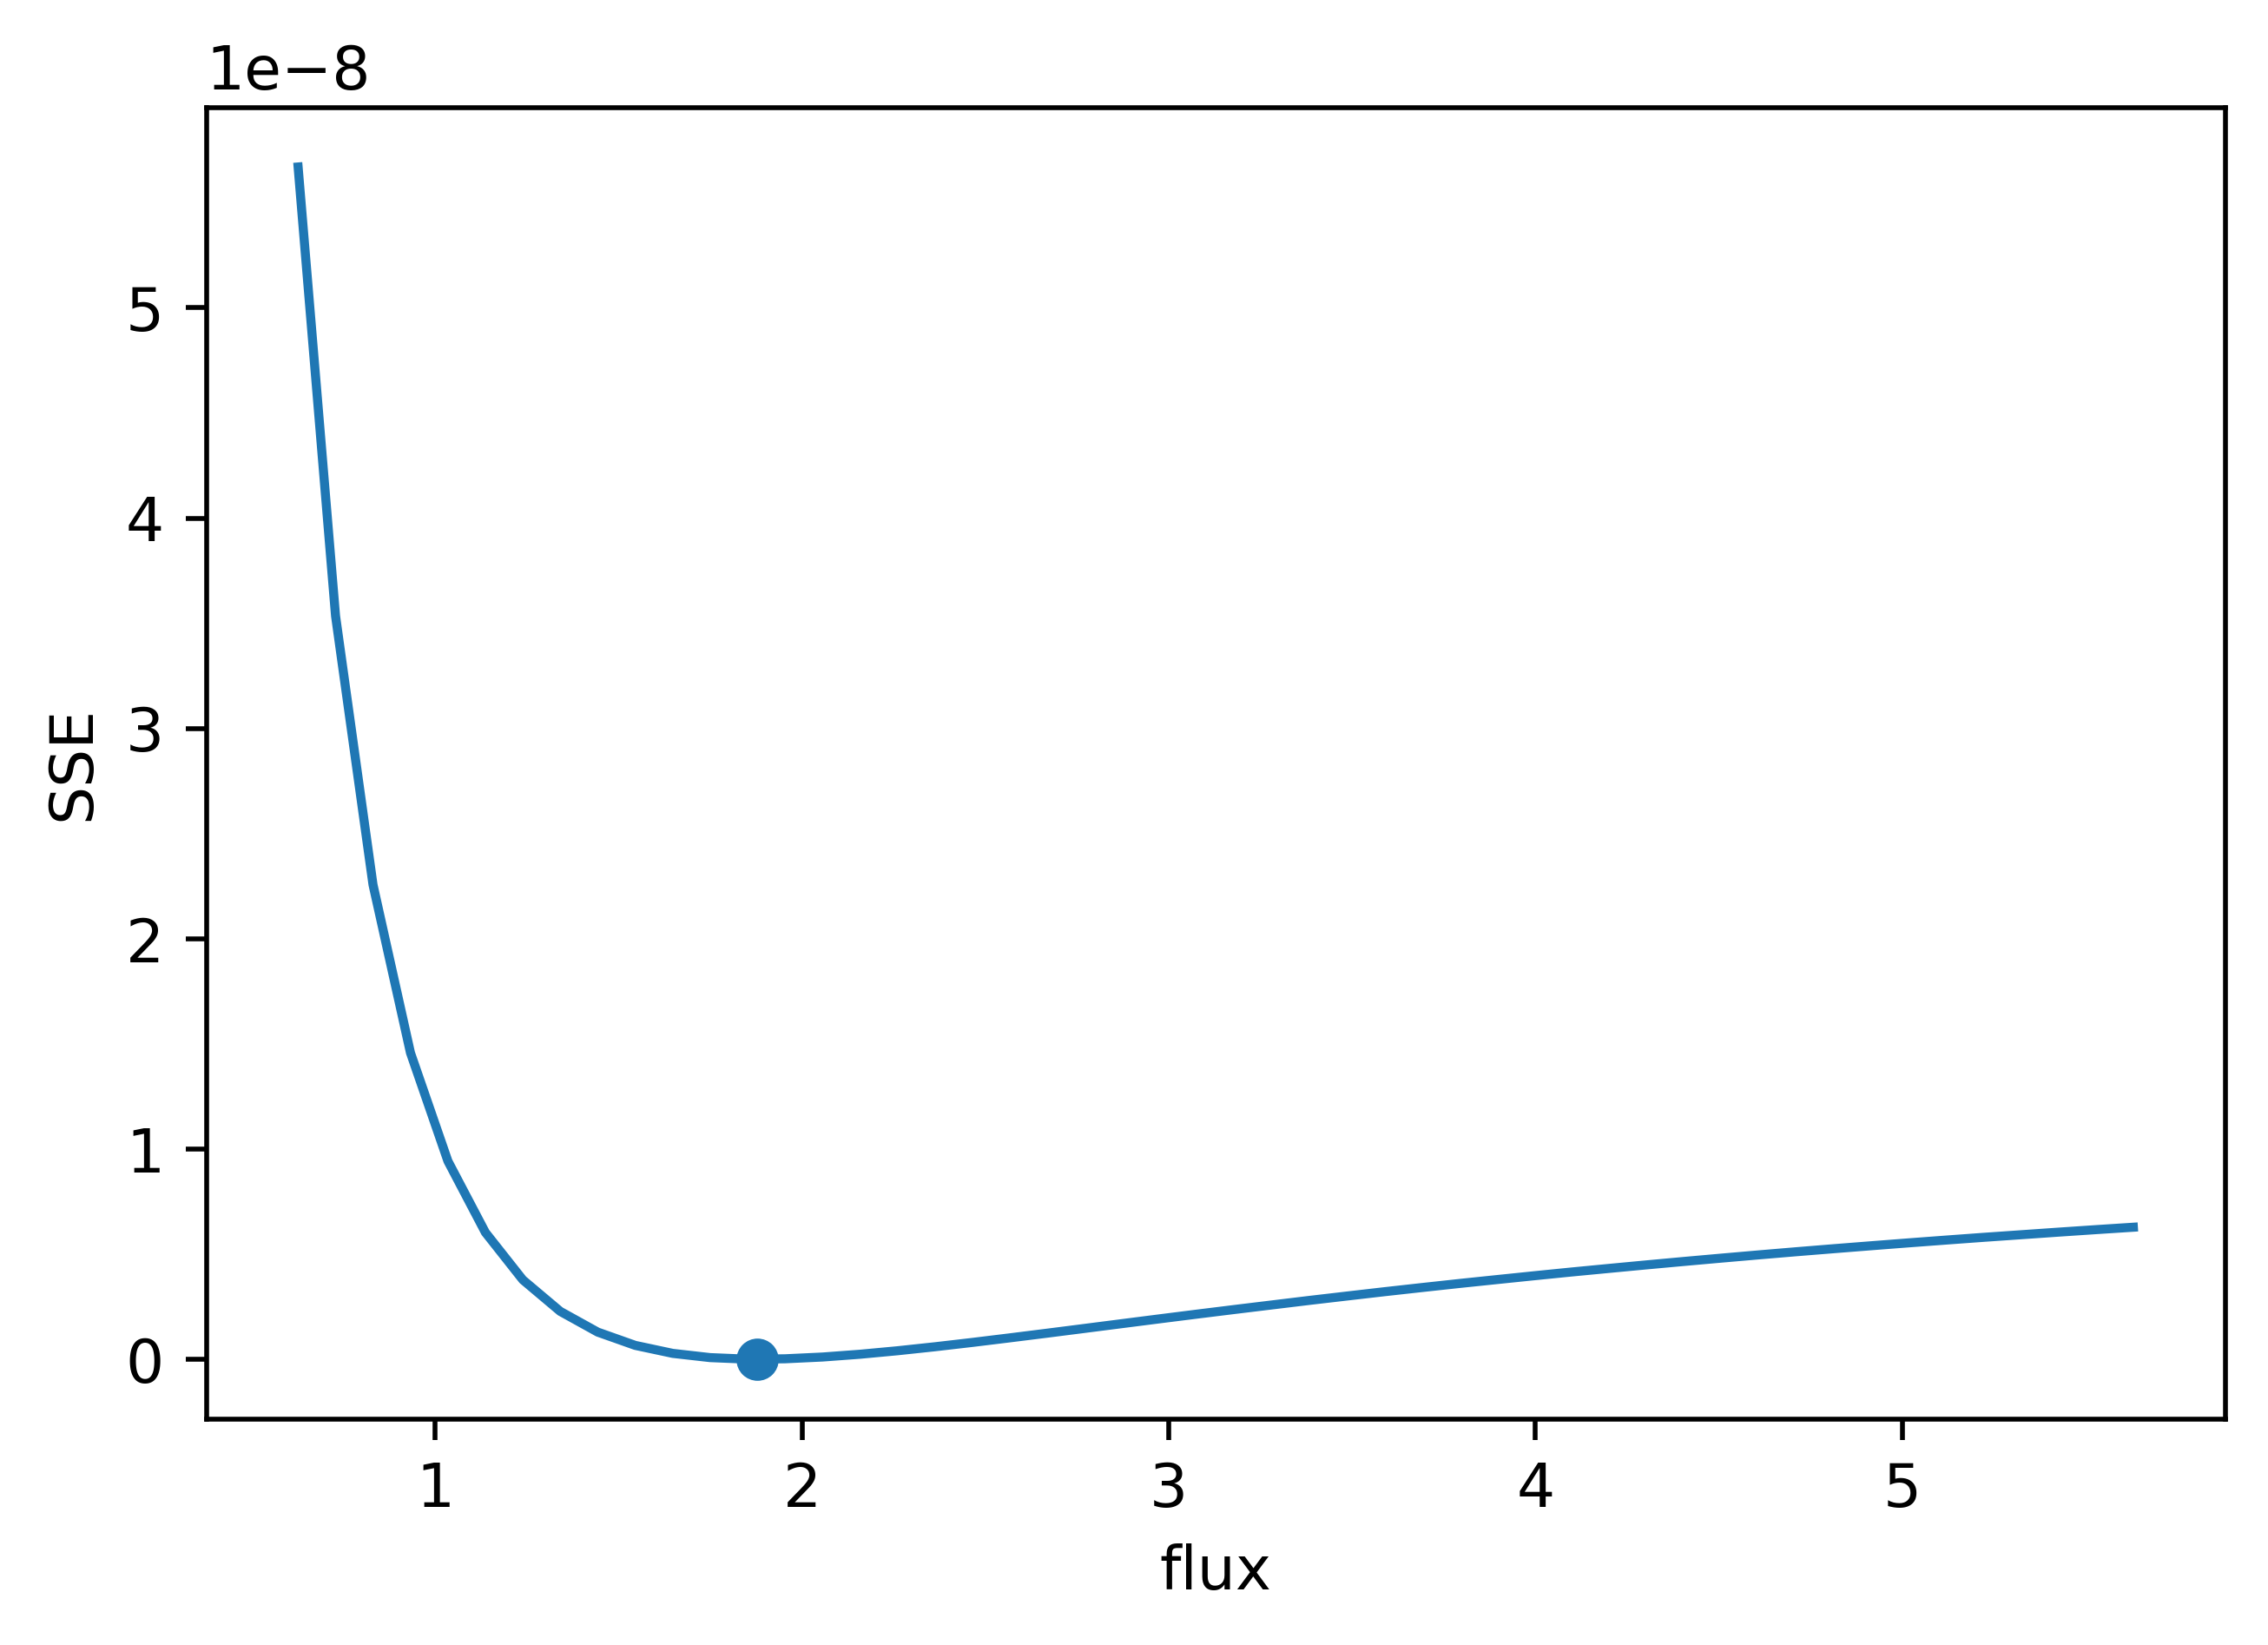

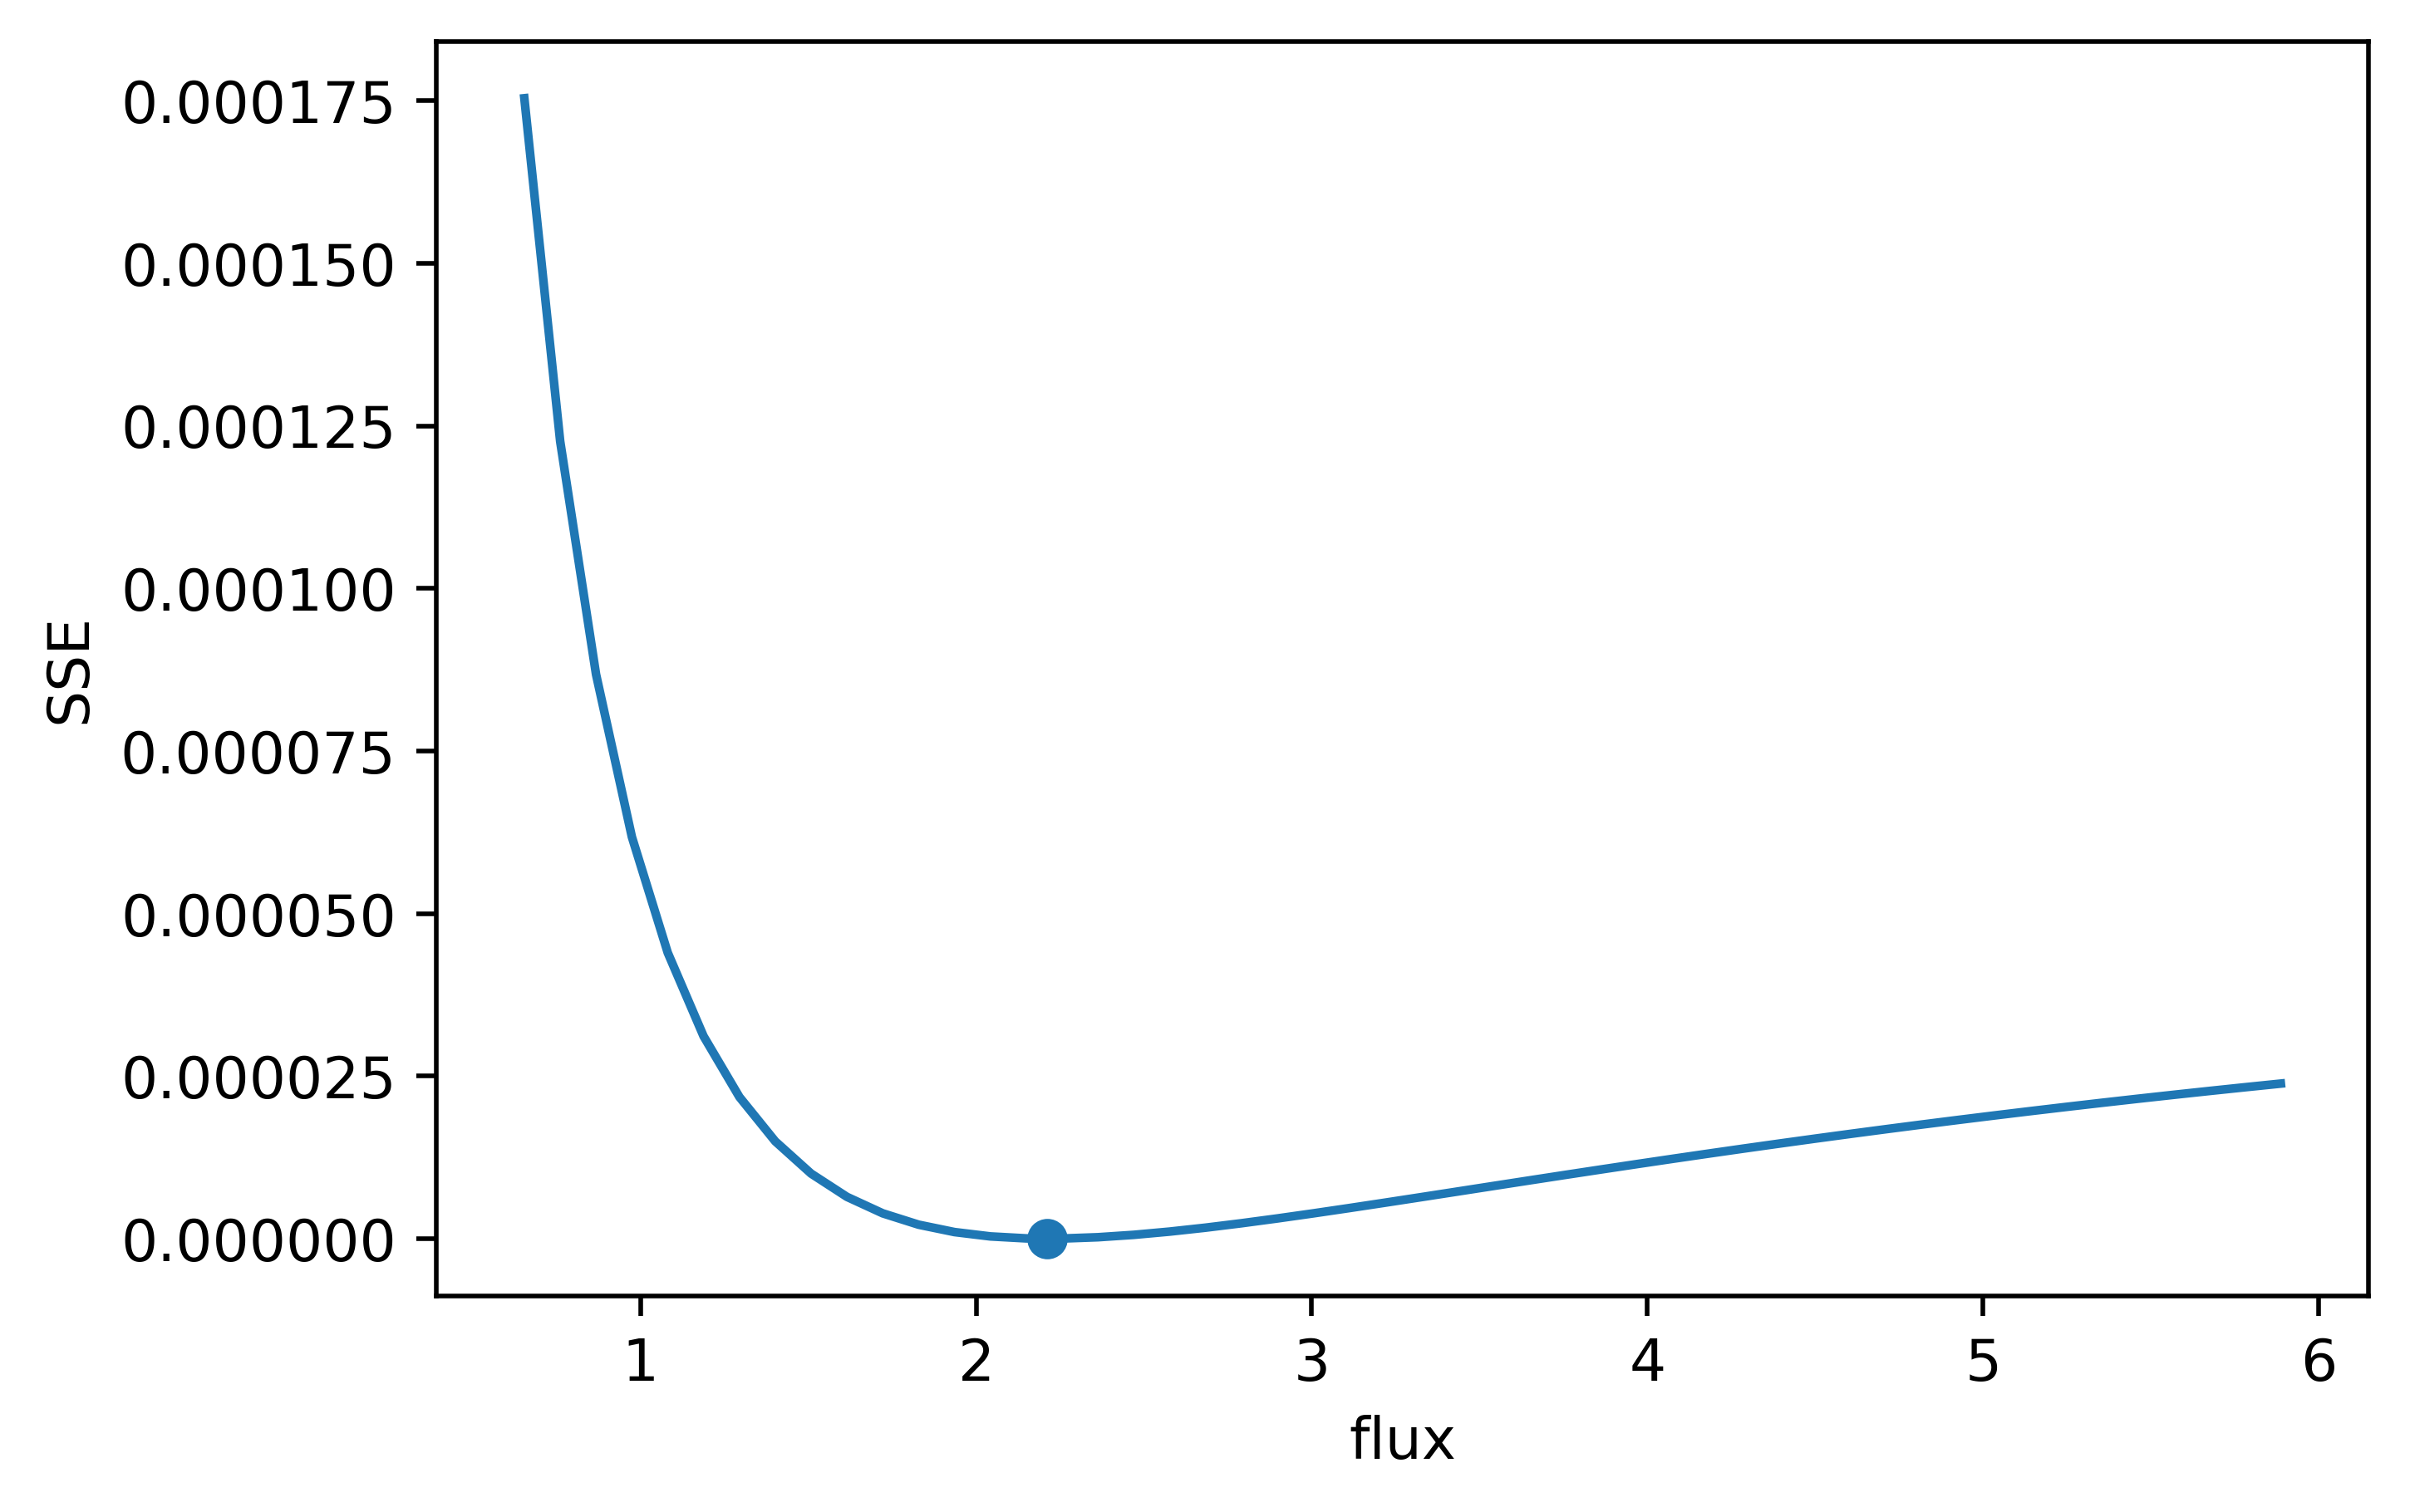

In [11]:
equations = [lactateEquation,g3pEquation,malateEquation,nadhEquation]
labels1 = ["UL_lac","UL_g3p","UL_malate","UL_nadh"]
labels2 = ["Lactate","G3P","Malate","NADH"]
for x in range(4):
    fluxes_to_try = np.linspace(fluxes[x]/3,3*fluxes[x])
    #fluxes_to_try = np.linspace(0,2*fluxes_inferred[x])
    errs = []
    for f in fluxes_to_try:
        val = integrateModel(equations[x],ts,(f,conc[labels2[x]],C0s_inferred[x] * f,nadh,dhap,vhvds),initialState[x],conc[labels2[x]])[:,0]
        err = sse(val,data[labels1[x]].values)#np.sum(np.abs(val-data["UL_nadh"].values))
        errs.append(err)
    f = fluxes_inferred[x]
    val = integrateModel(equations[x],ts,(f,conc[labels2[x]],(1-labeled_contributions[x])/labeled_contributions[x] * f,nadh,dhap),initialState[x],conc[labels2[x]])[:,0]
    err = sse(val,data[labels1[x]].values)
    plt.figure()
    plt.plot(fluxes_to_try,errs)
    plt.ylabel("SSE")
    plt.xlabel("flux")
    plt.scatter([f],[err])
#plt.xlim((0,20000))

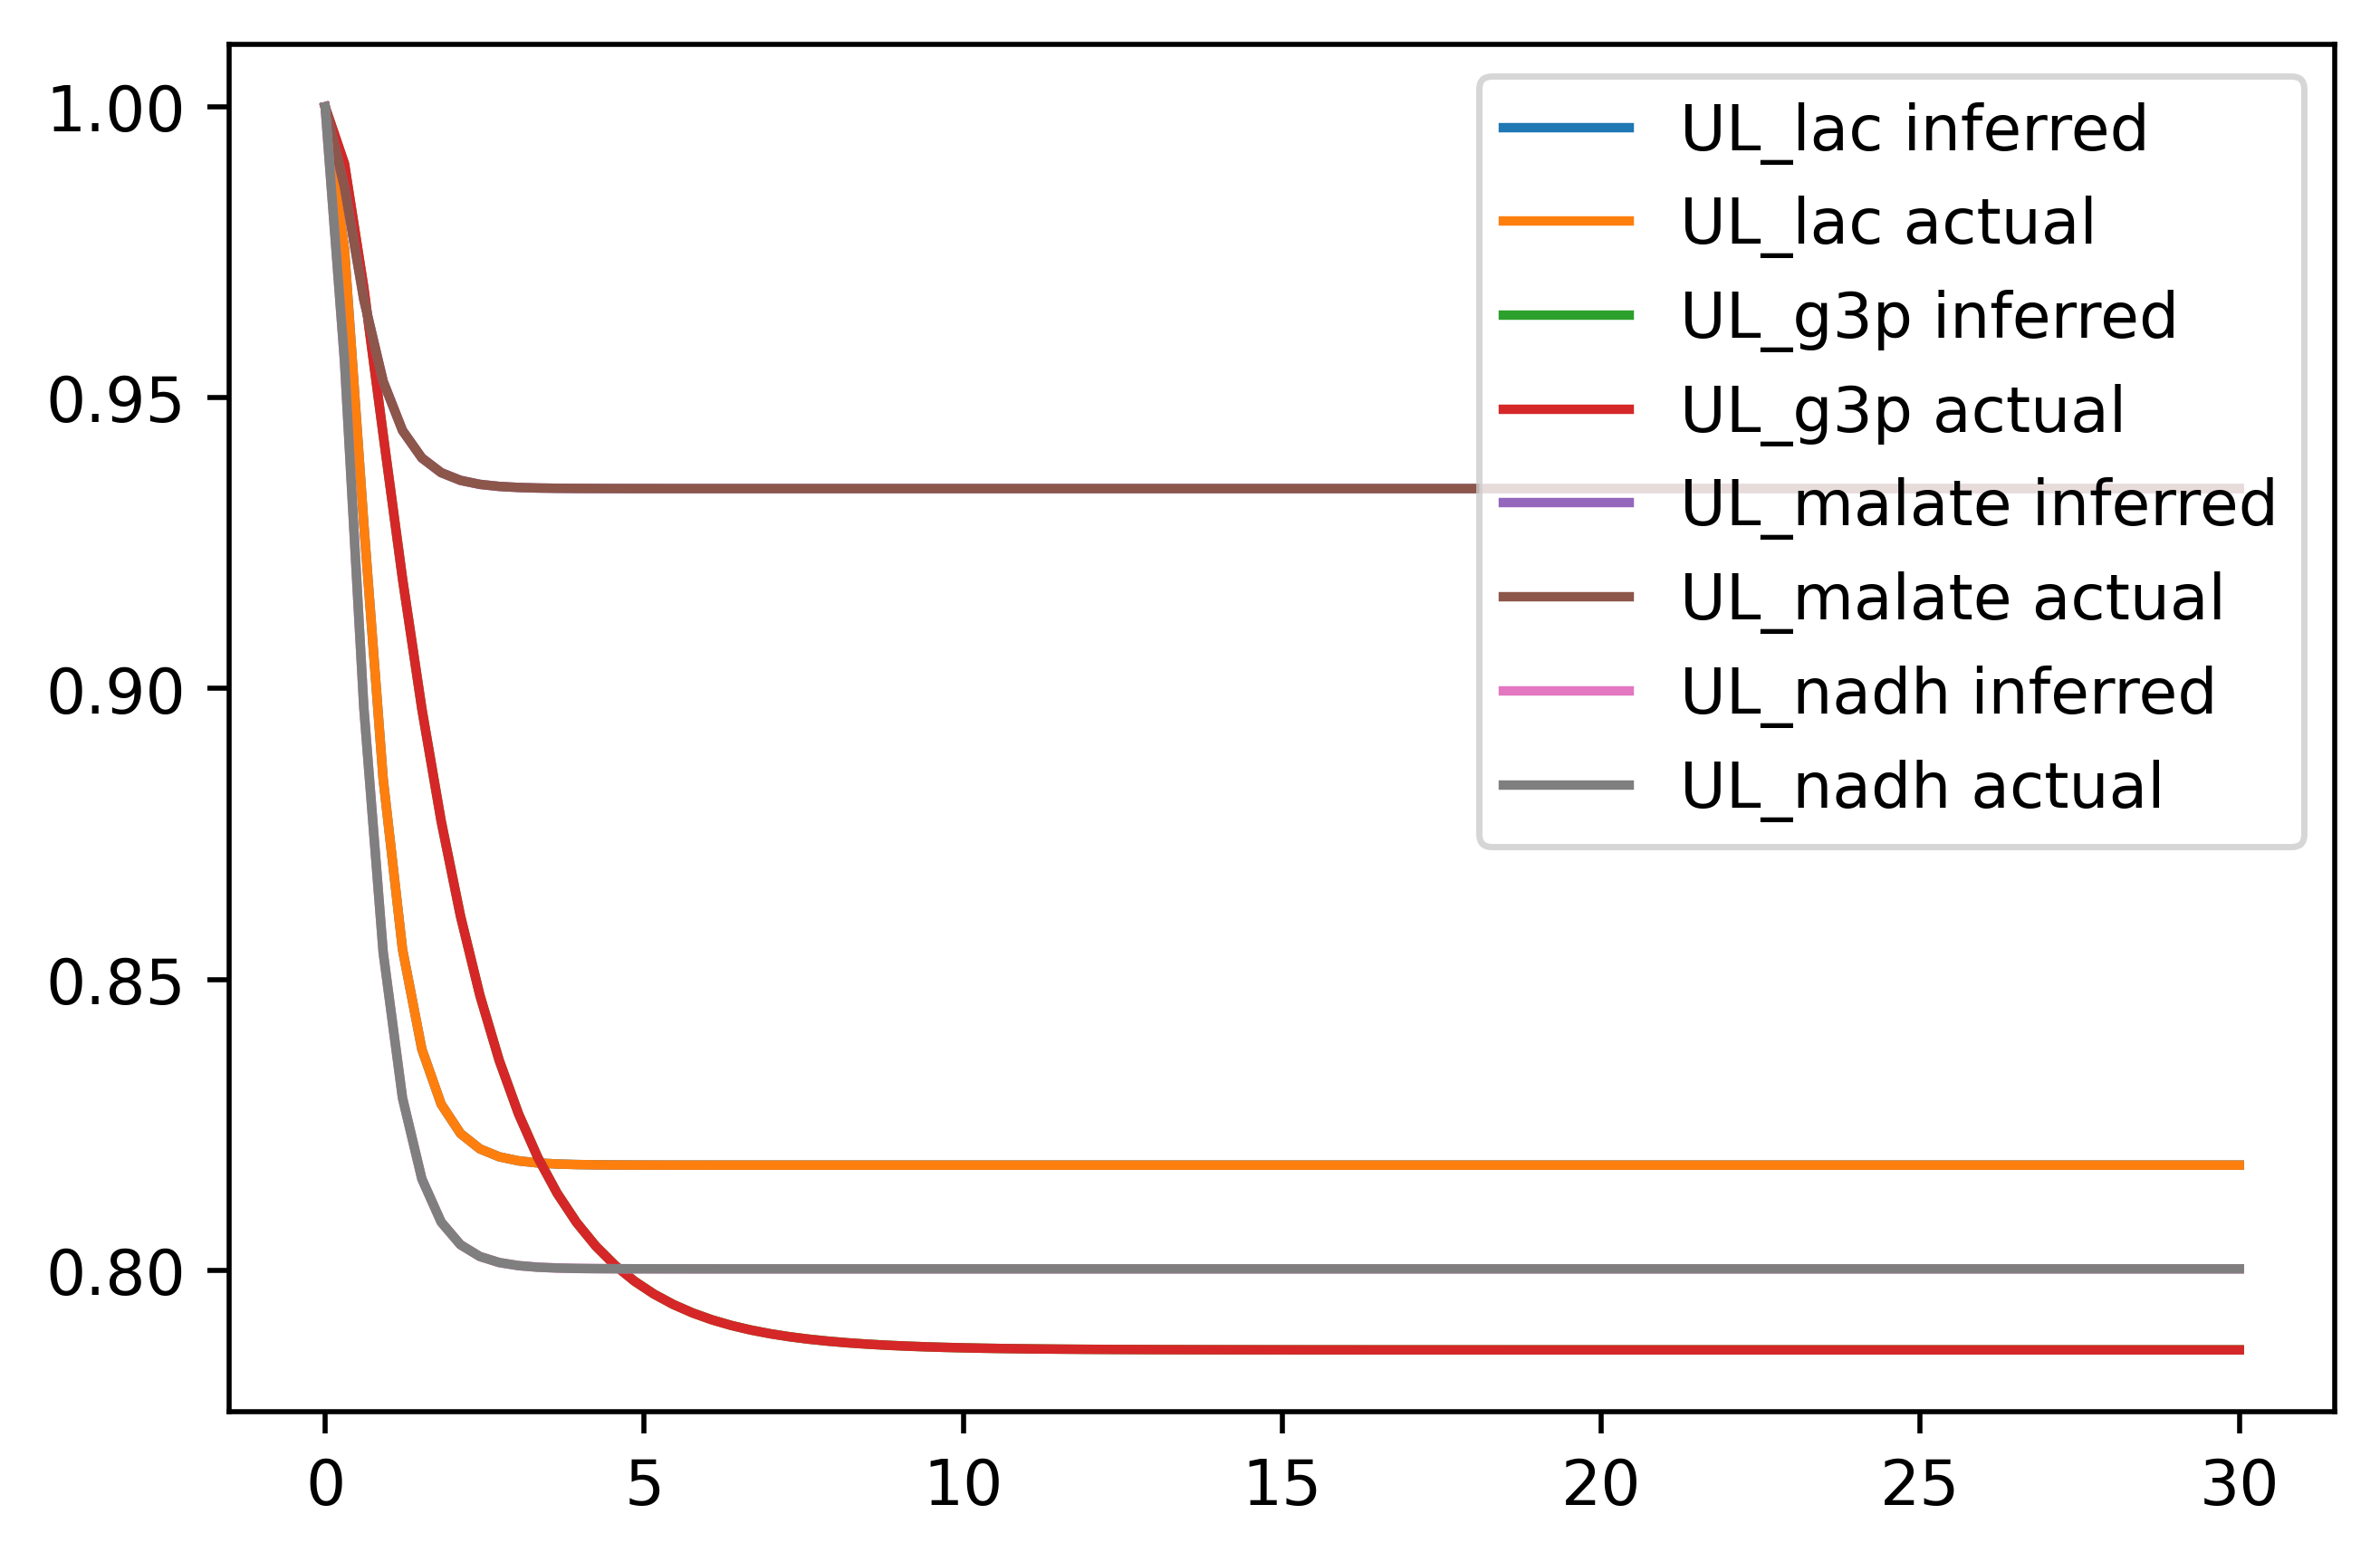

In [13]:
values = integrateLabelingModel(ts, fluxes_inferred,conc,dhap_params,labeled_contributions,initialState)
inferred = pd.DataFrame(data=values,columns=["UL_lac","UL_g3p","UL_malate","UL_nadh"])
for col in ["UL_lac","UL_g3p","UL_malate","UL_nadh"]:
    plt.plot(ts,inferred[col],label=col + " inferred")
    plt.plot(ts,data[col],label=col+" actual")
plt.legend()


In [14]:
if __name__ == '__main__':
    true = []
    pred = []
    err = []
    args = [[ts,numBestFitIters] for _ in range(numSims)]
    result = startConcurrentTask(simulateDataAndInferFlux,args,numCores,"running simulations",len(args))
    for fluxes,(inferred_fluxes,_,_,conc,errs) in result:
        true.append(fluxes)
        pred.append(inferred_fluxes)
        err.append(errs)
true = np.array(true)
pred = np.array(pred)
err = np.array(err)

running simulations |██████████████████████████████████████████████████| 100.0% 


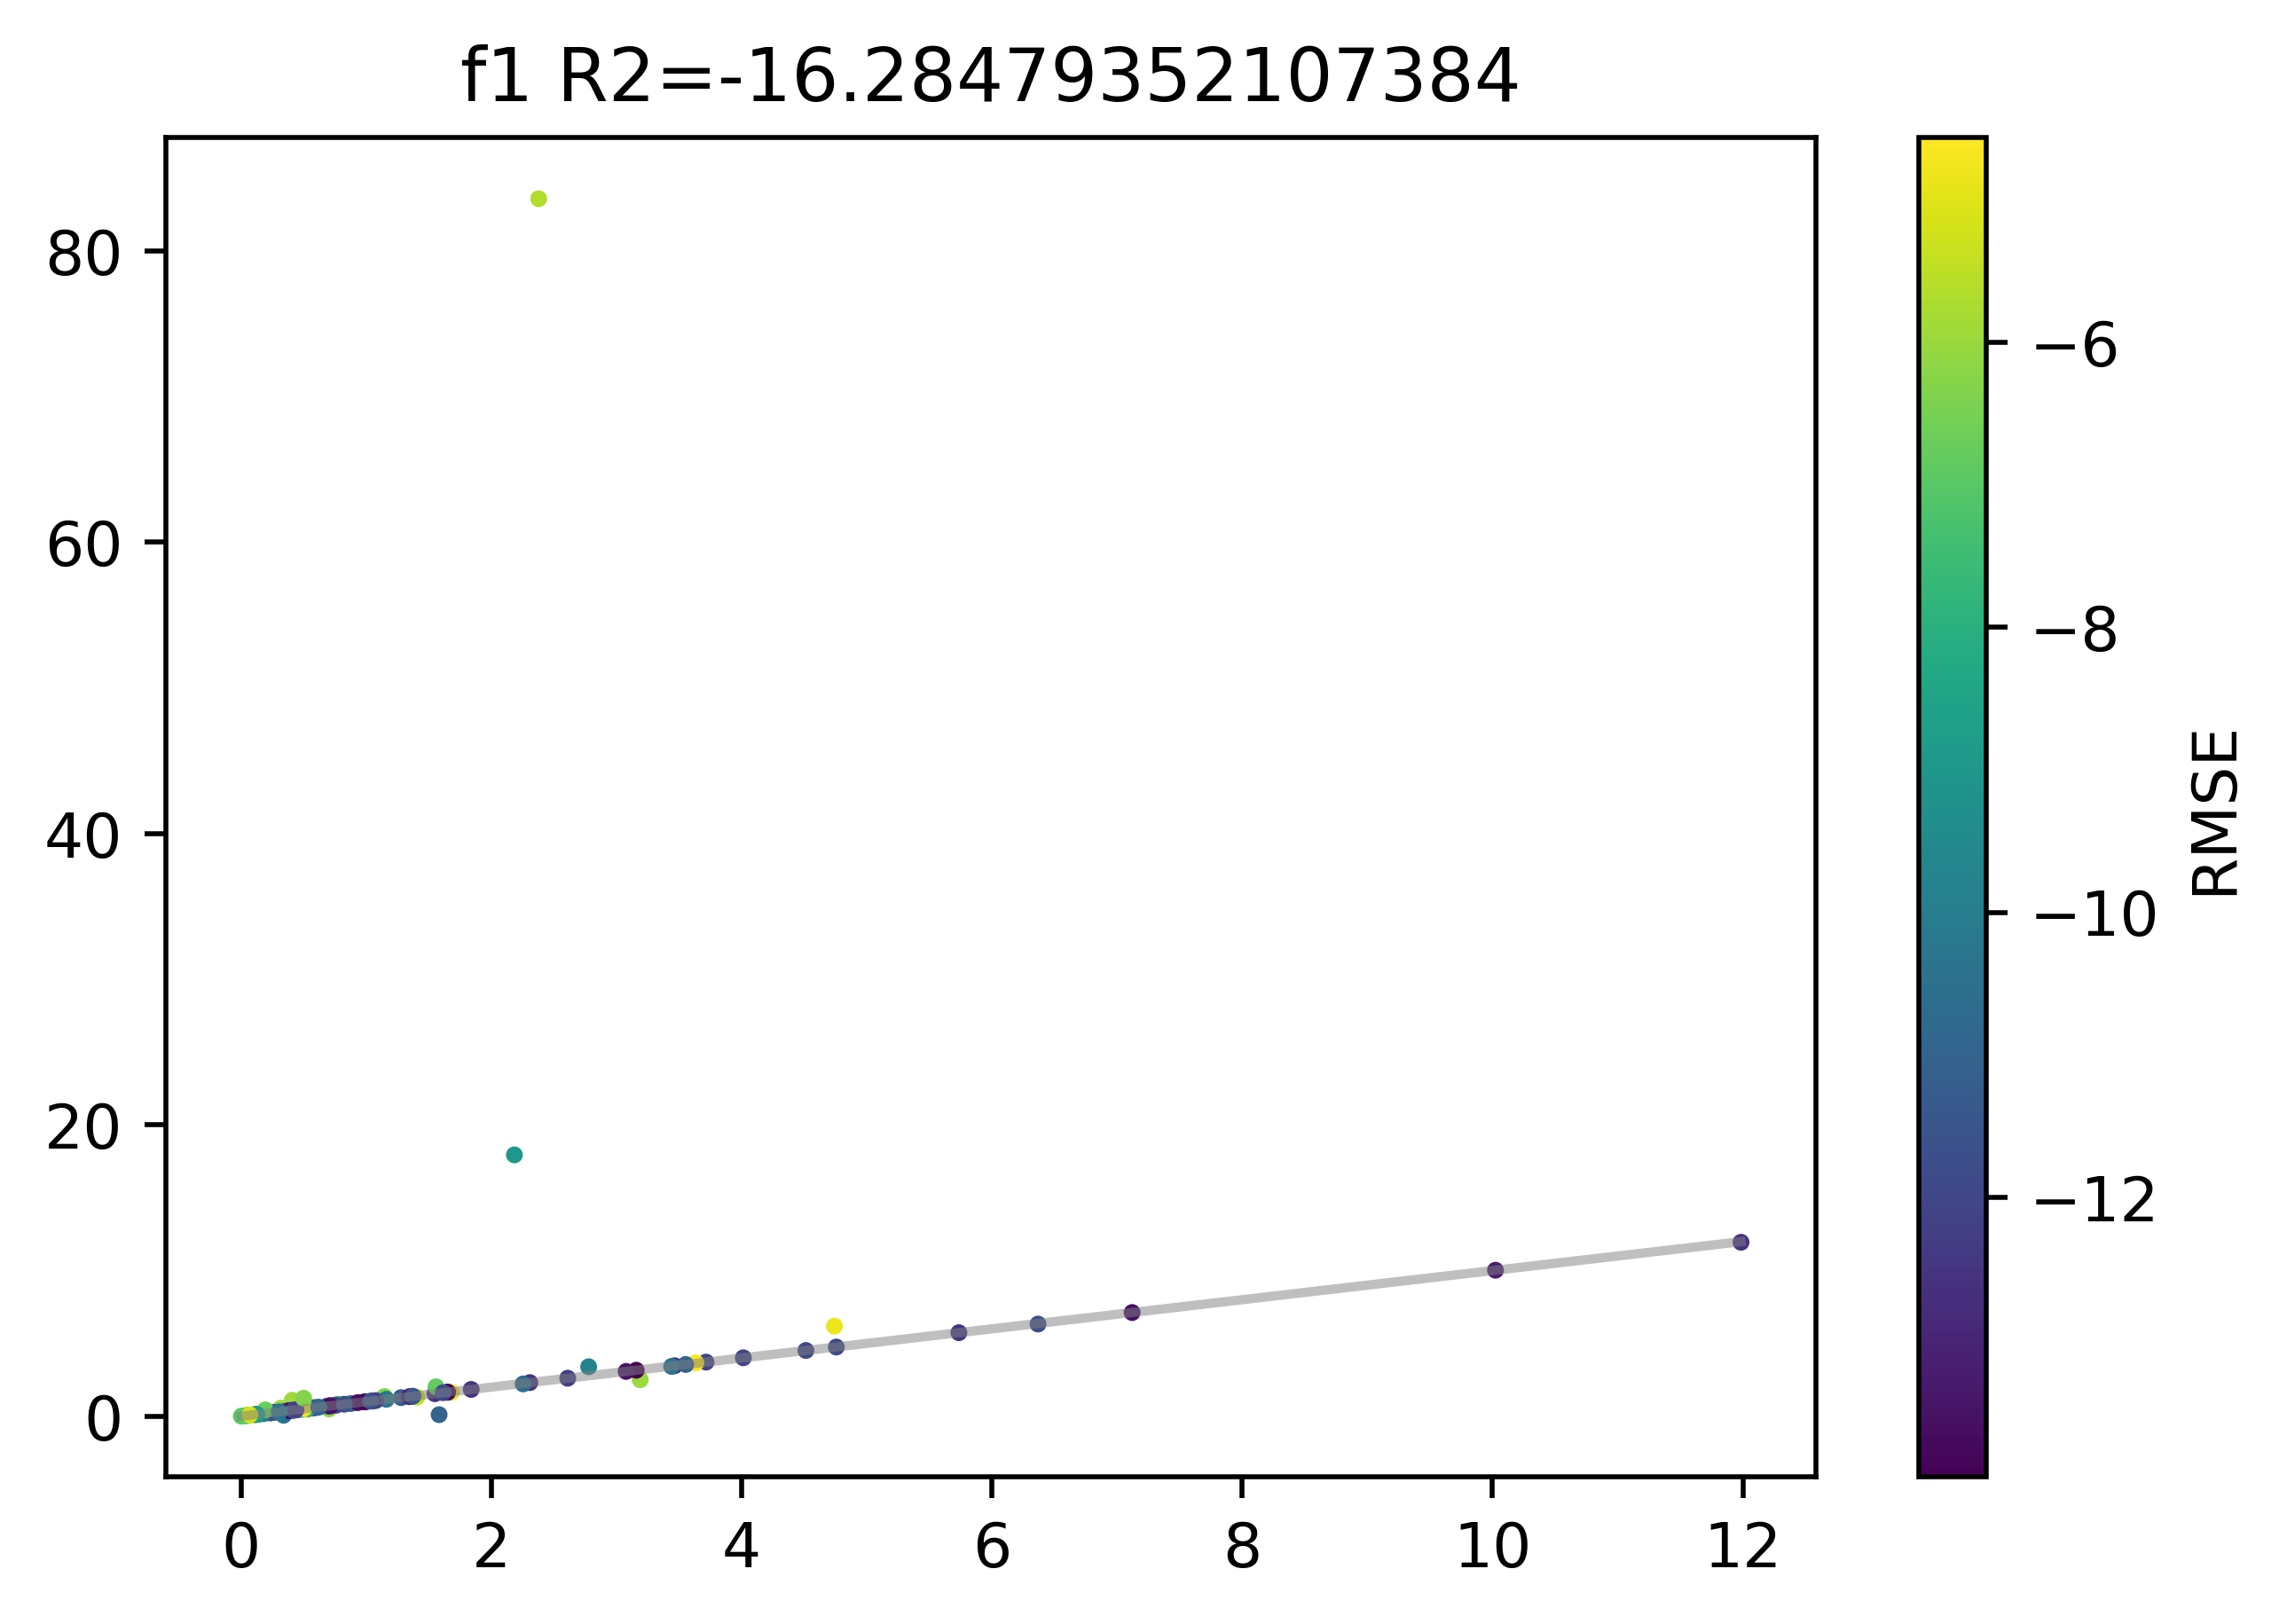

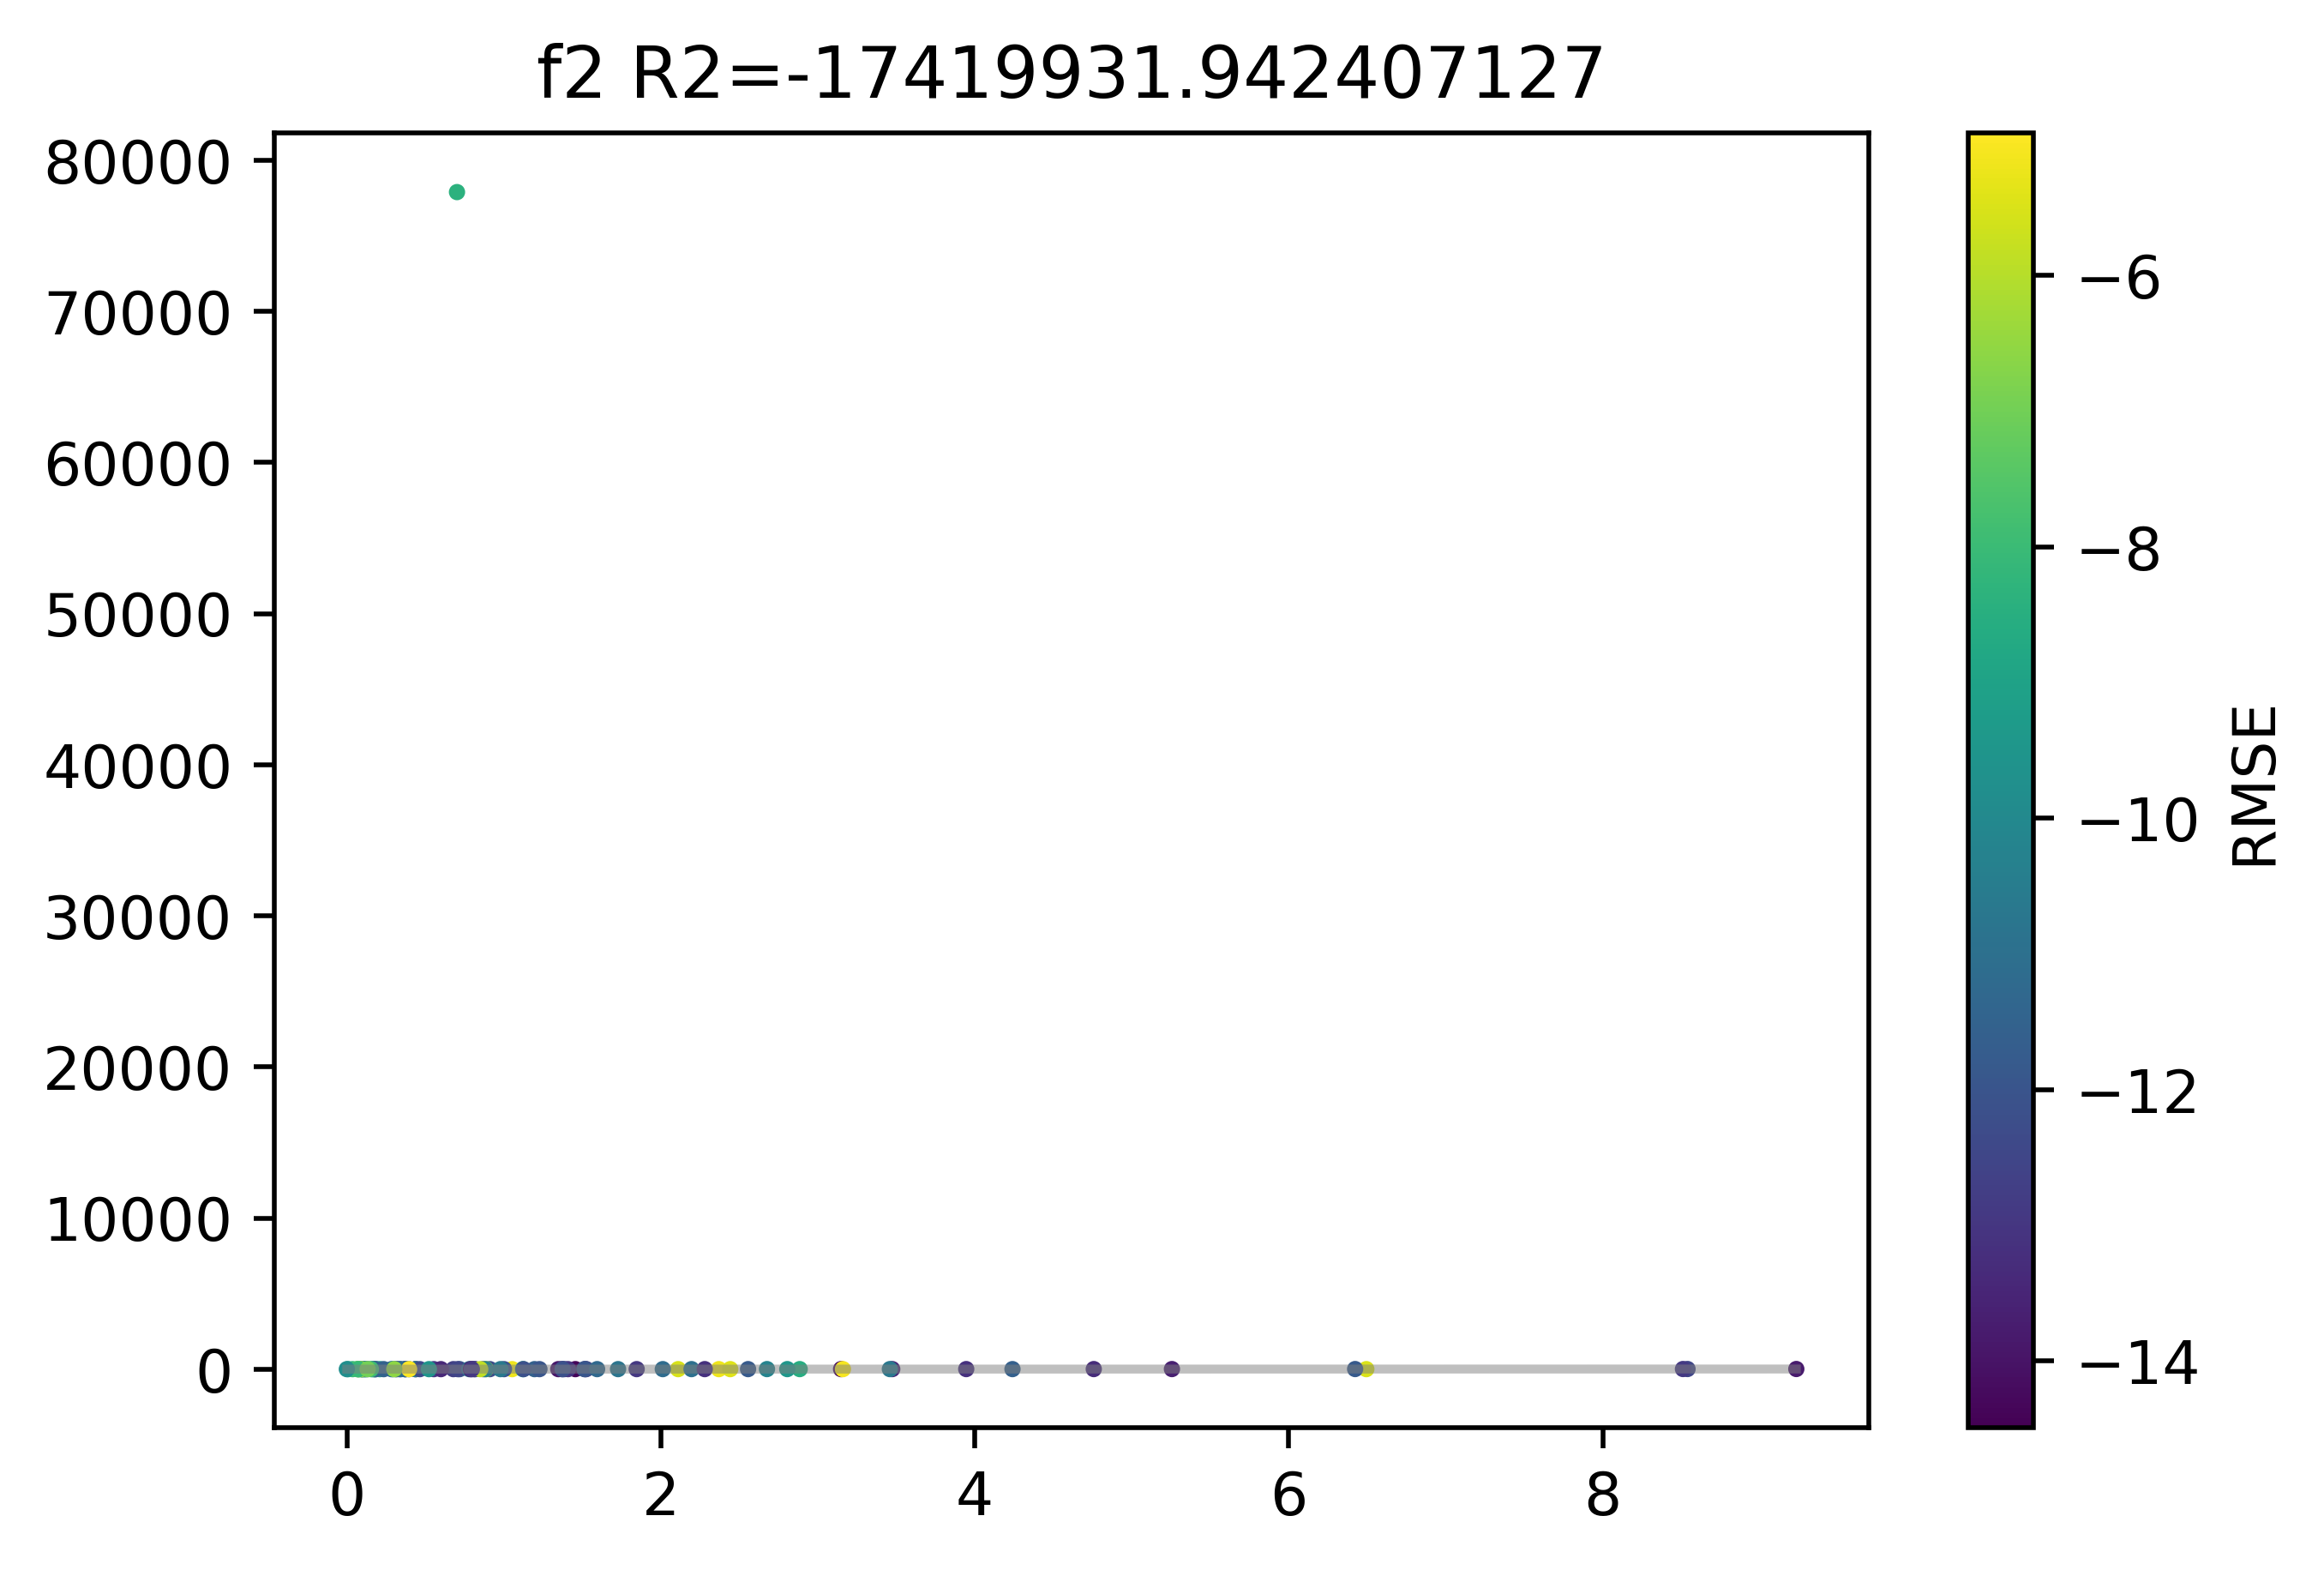

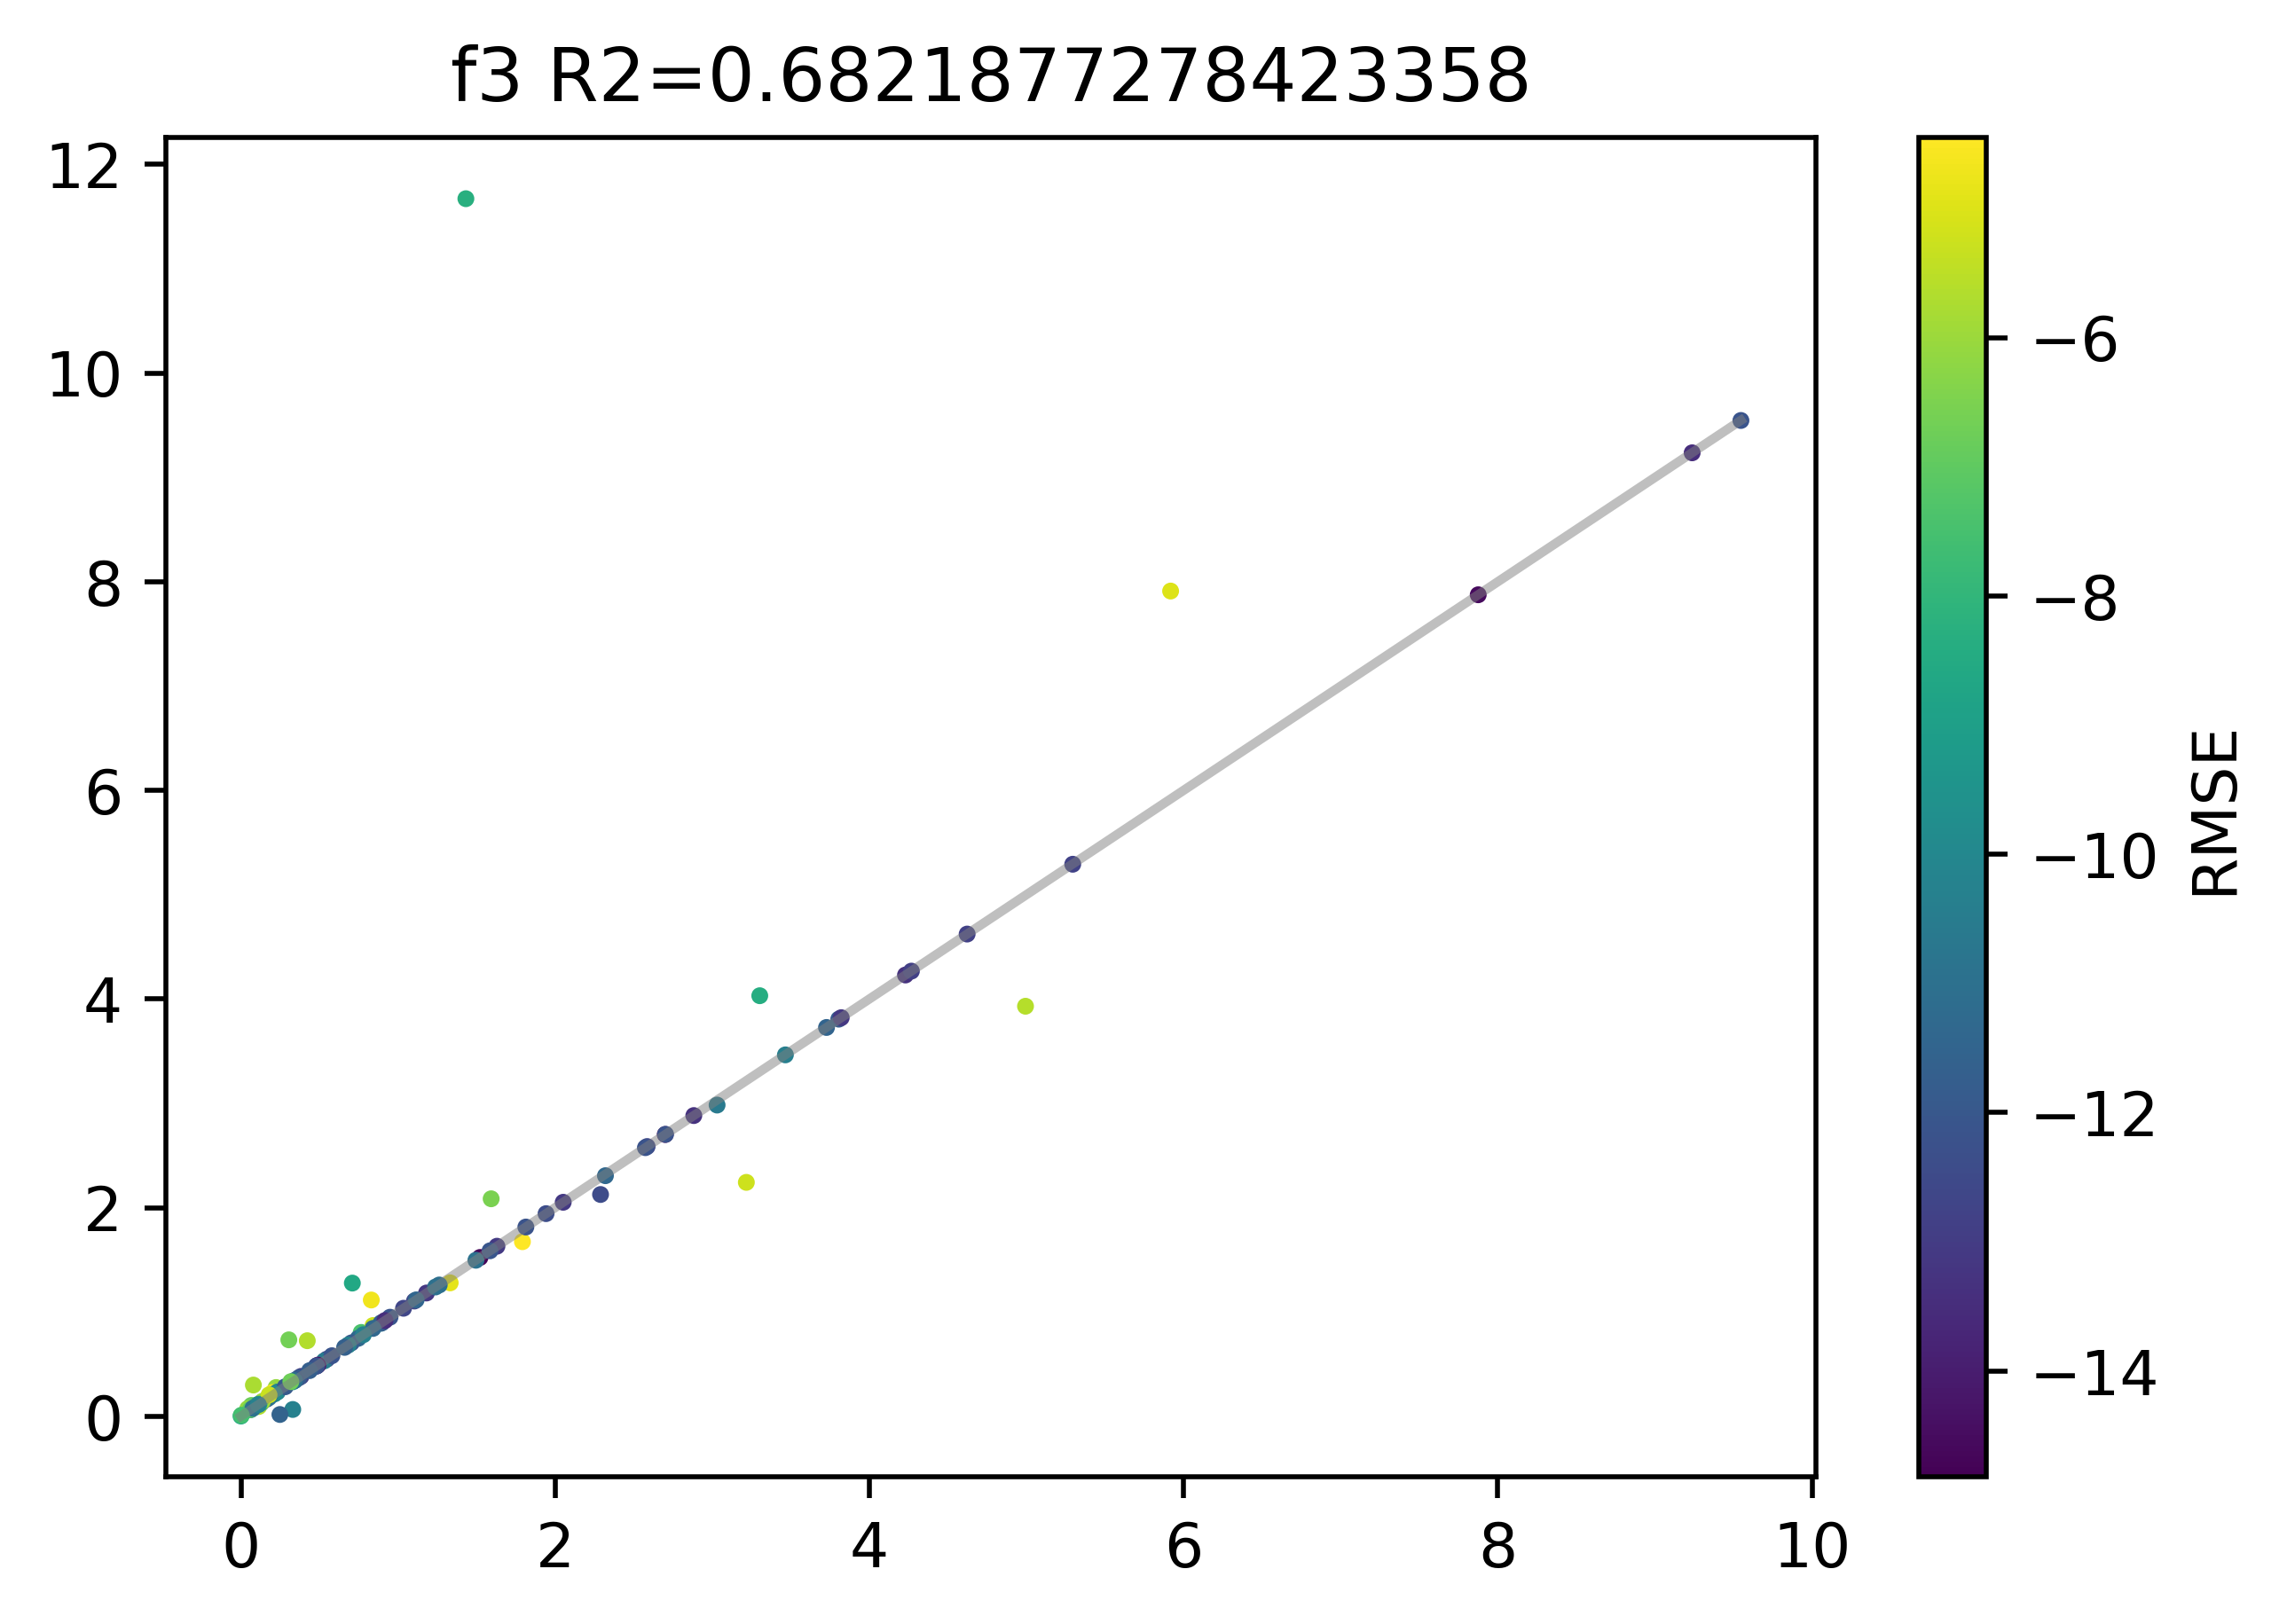

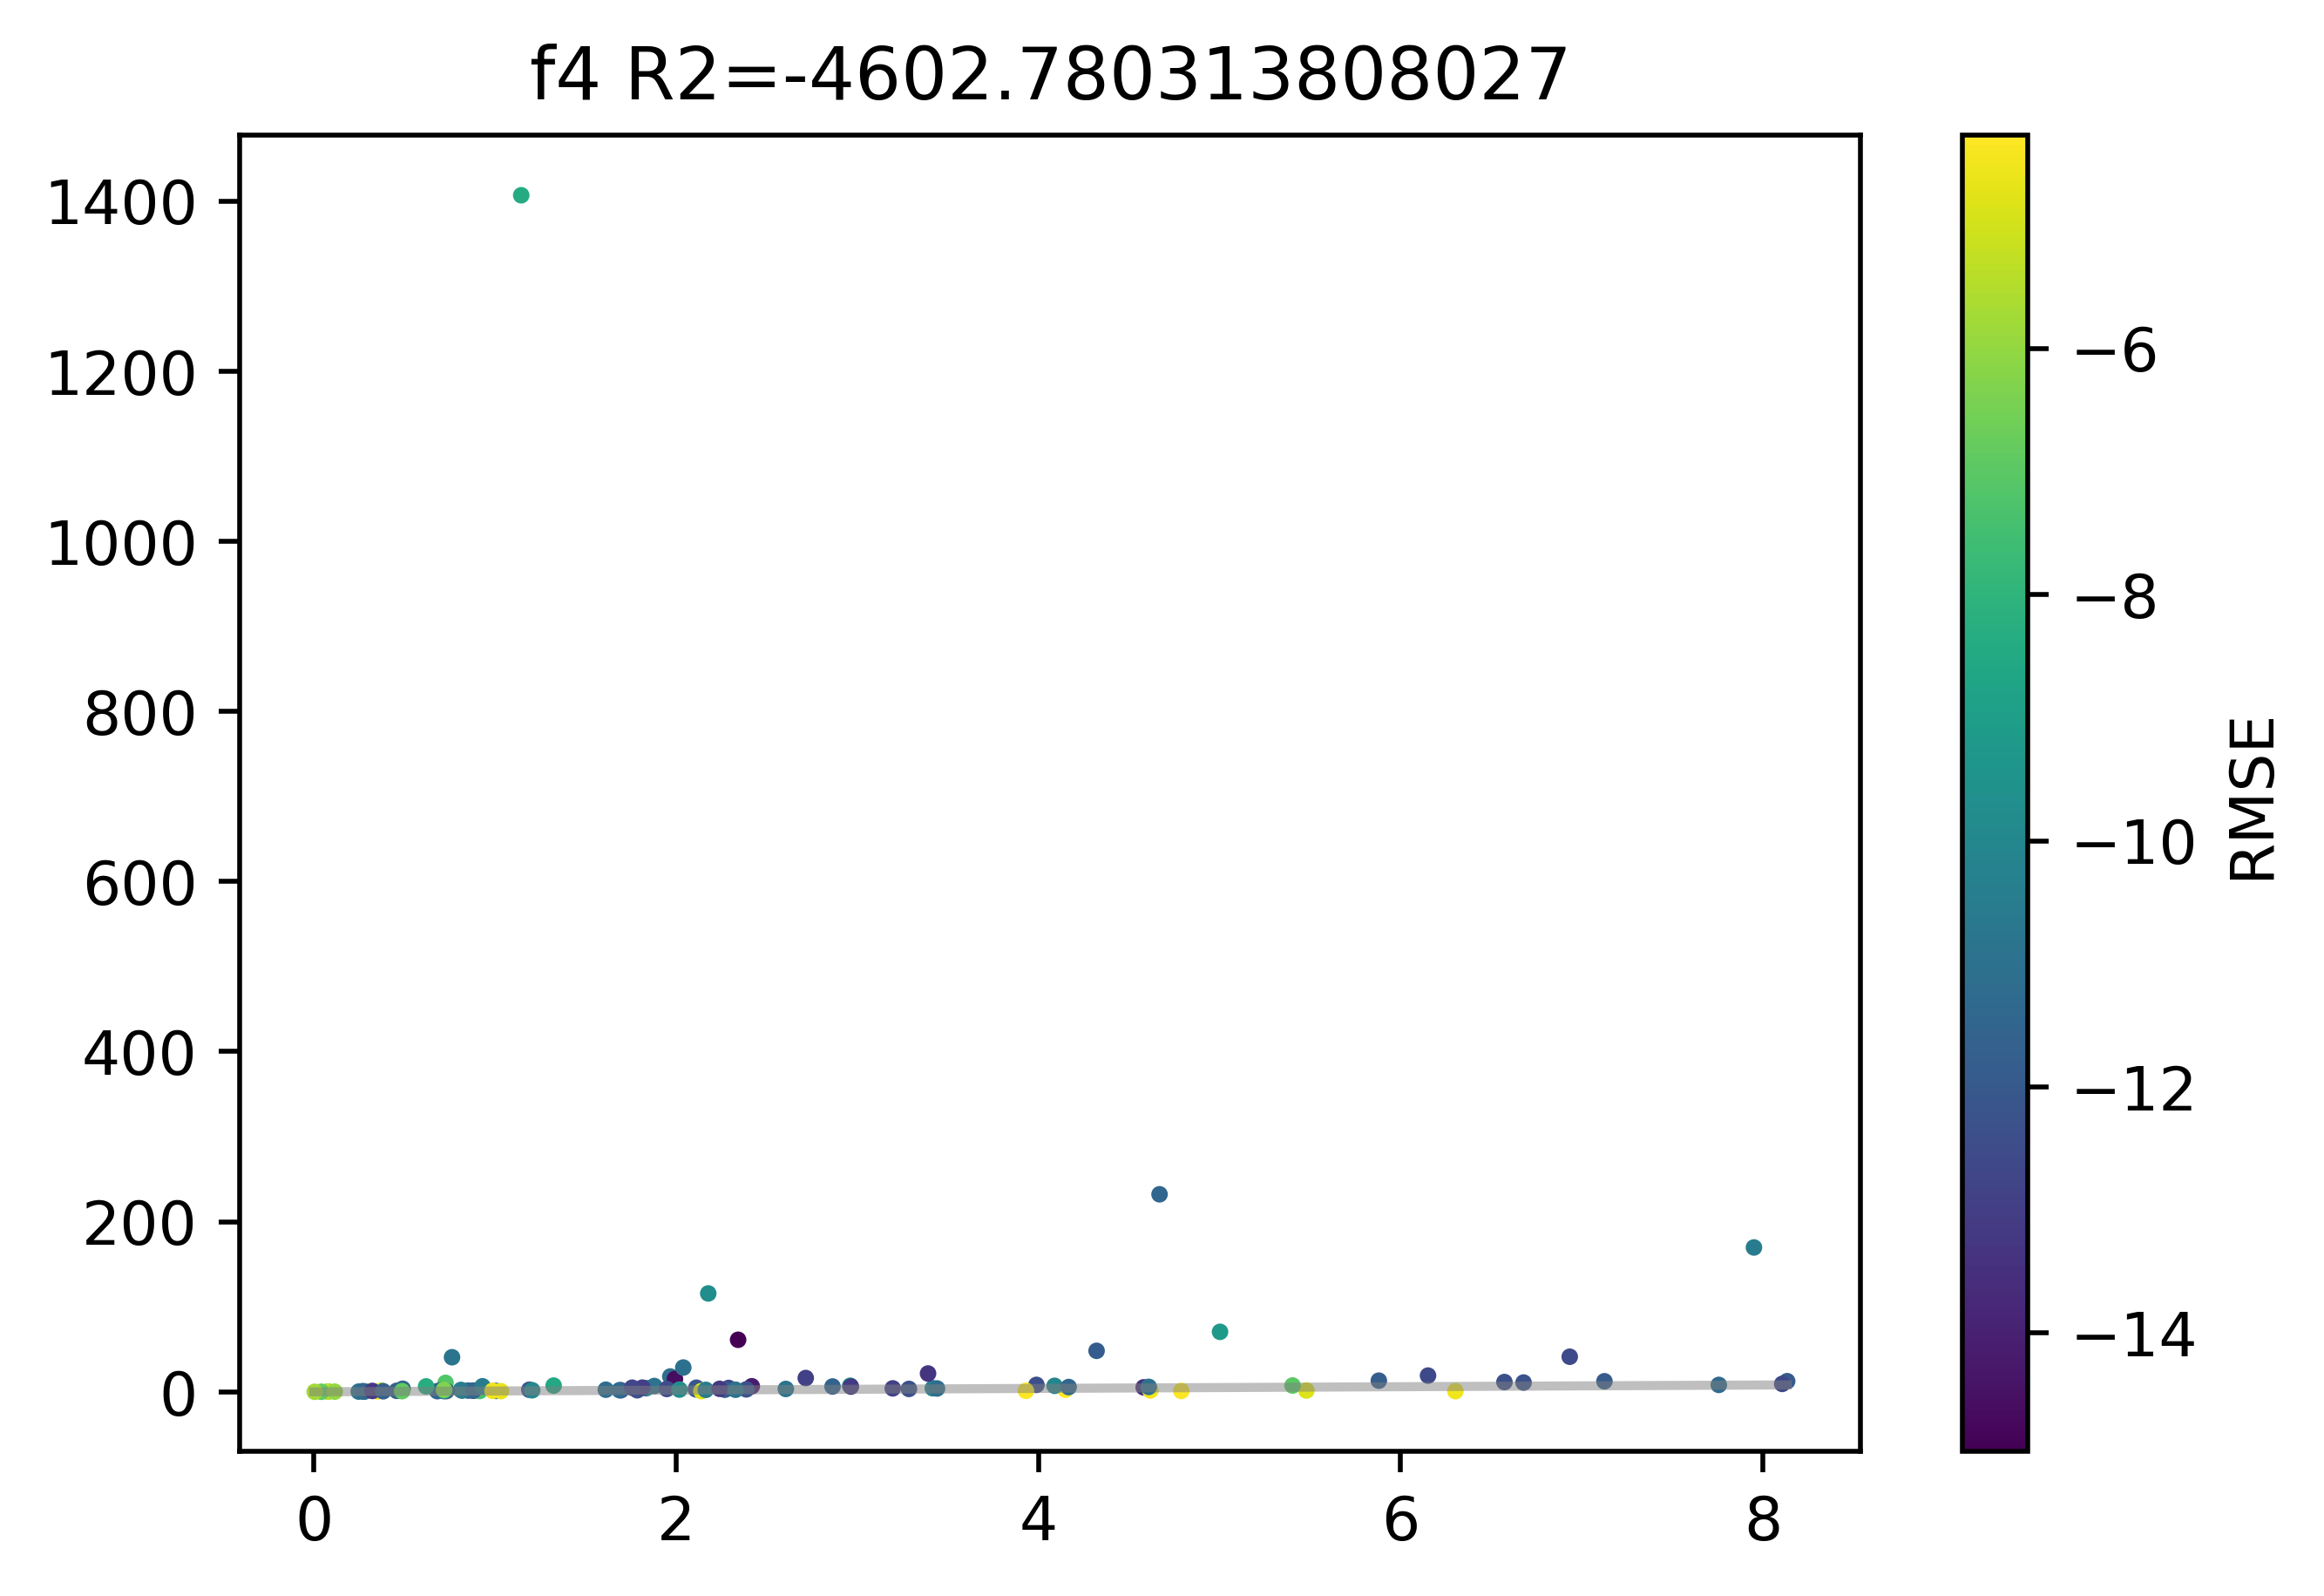

In [15]:
for x in range(pred.shape[1]):
    plt.figure()
    plt.scatter(true[:,x],pred[:,x],s=3,c=np.log10(err[:,x]))
    plt.plot([0,max(true[:,x])],[0,max(true[:,x])],color="grey",alpha=.5)
    plt.title("f" + str(x+1) + " R2=" + str(r2_score(true[:,x],pred[:,x])))
    plt.colorbar(label="RMSE")

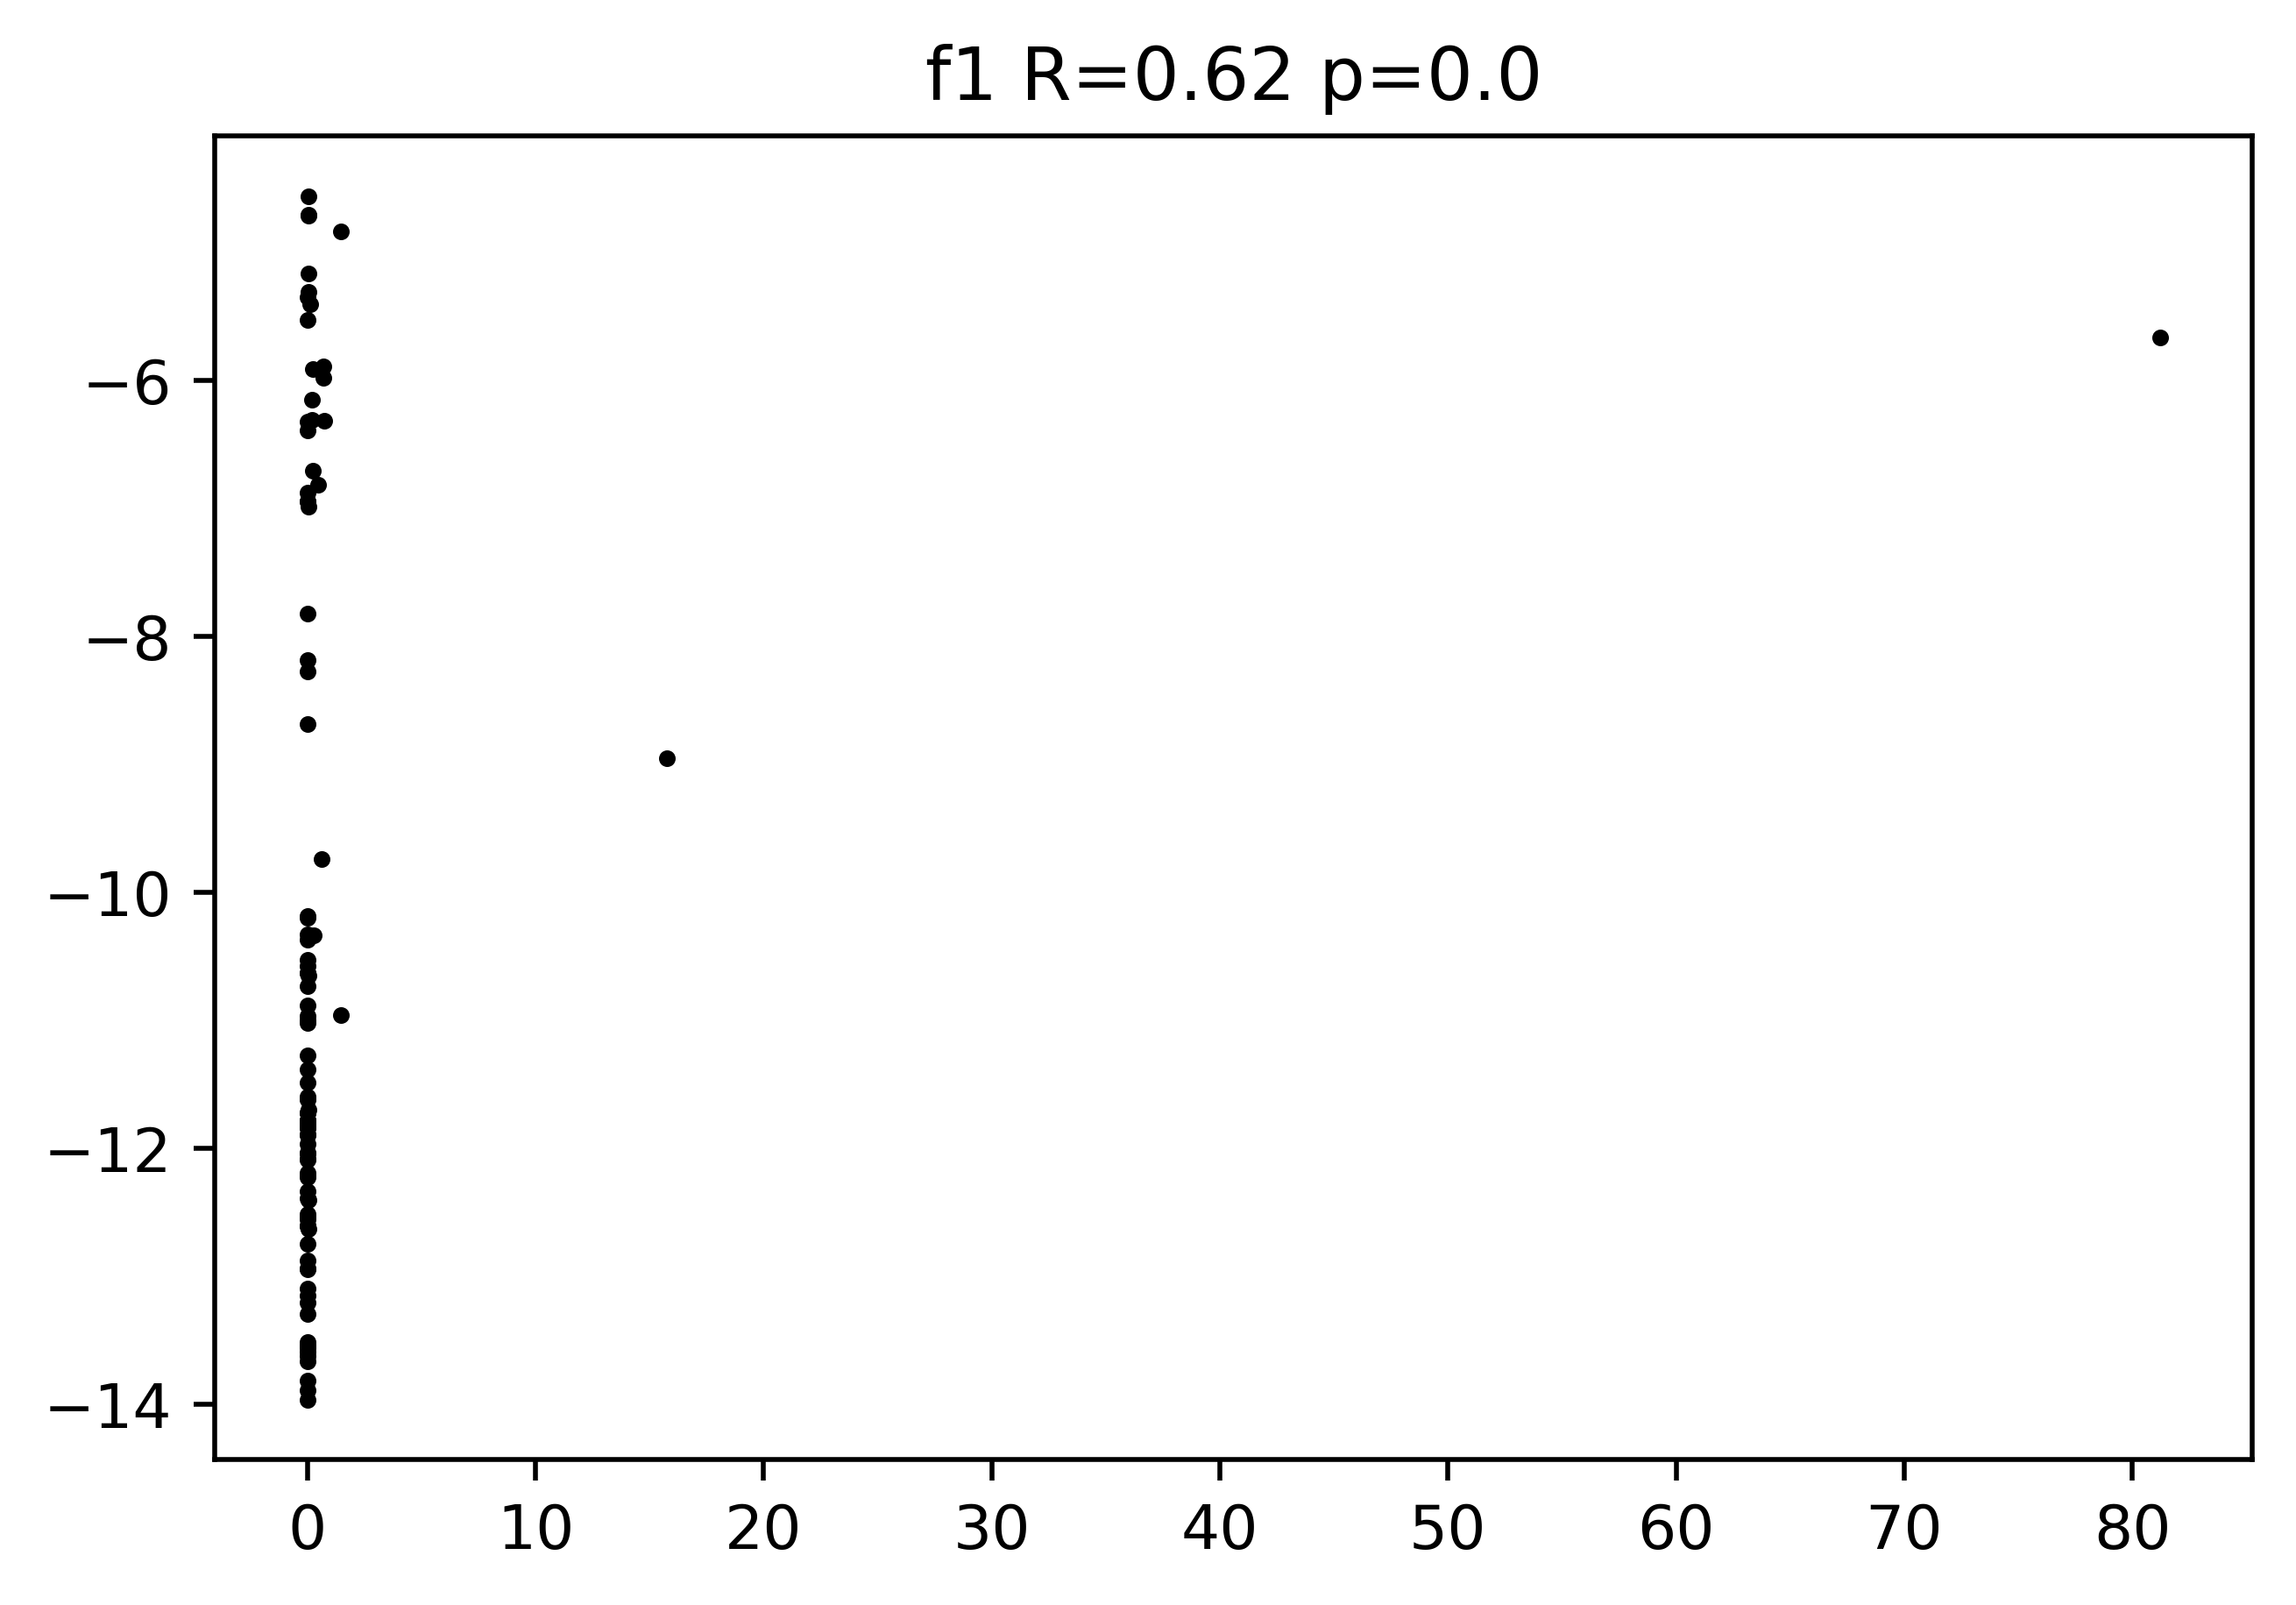

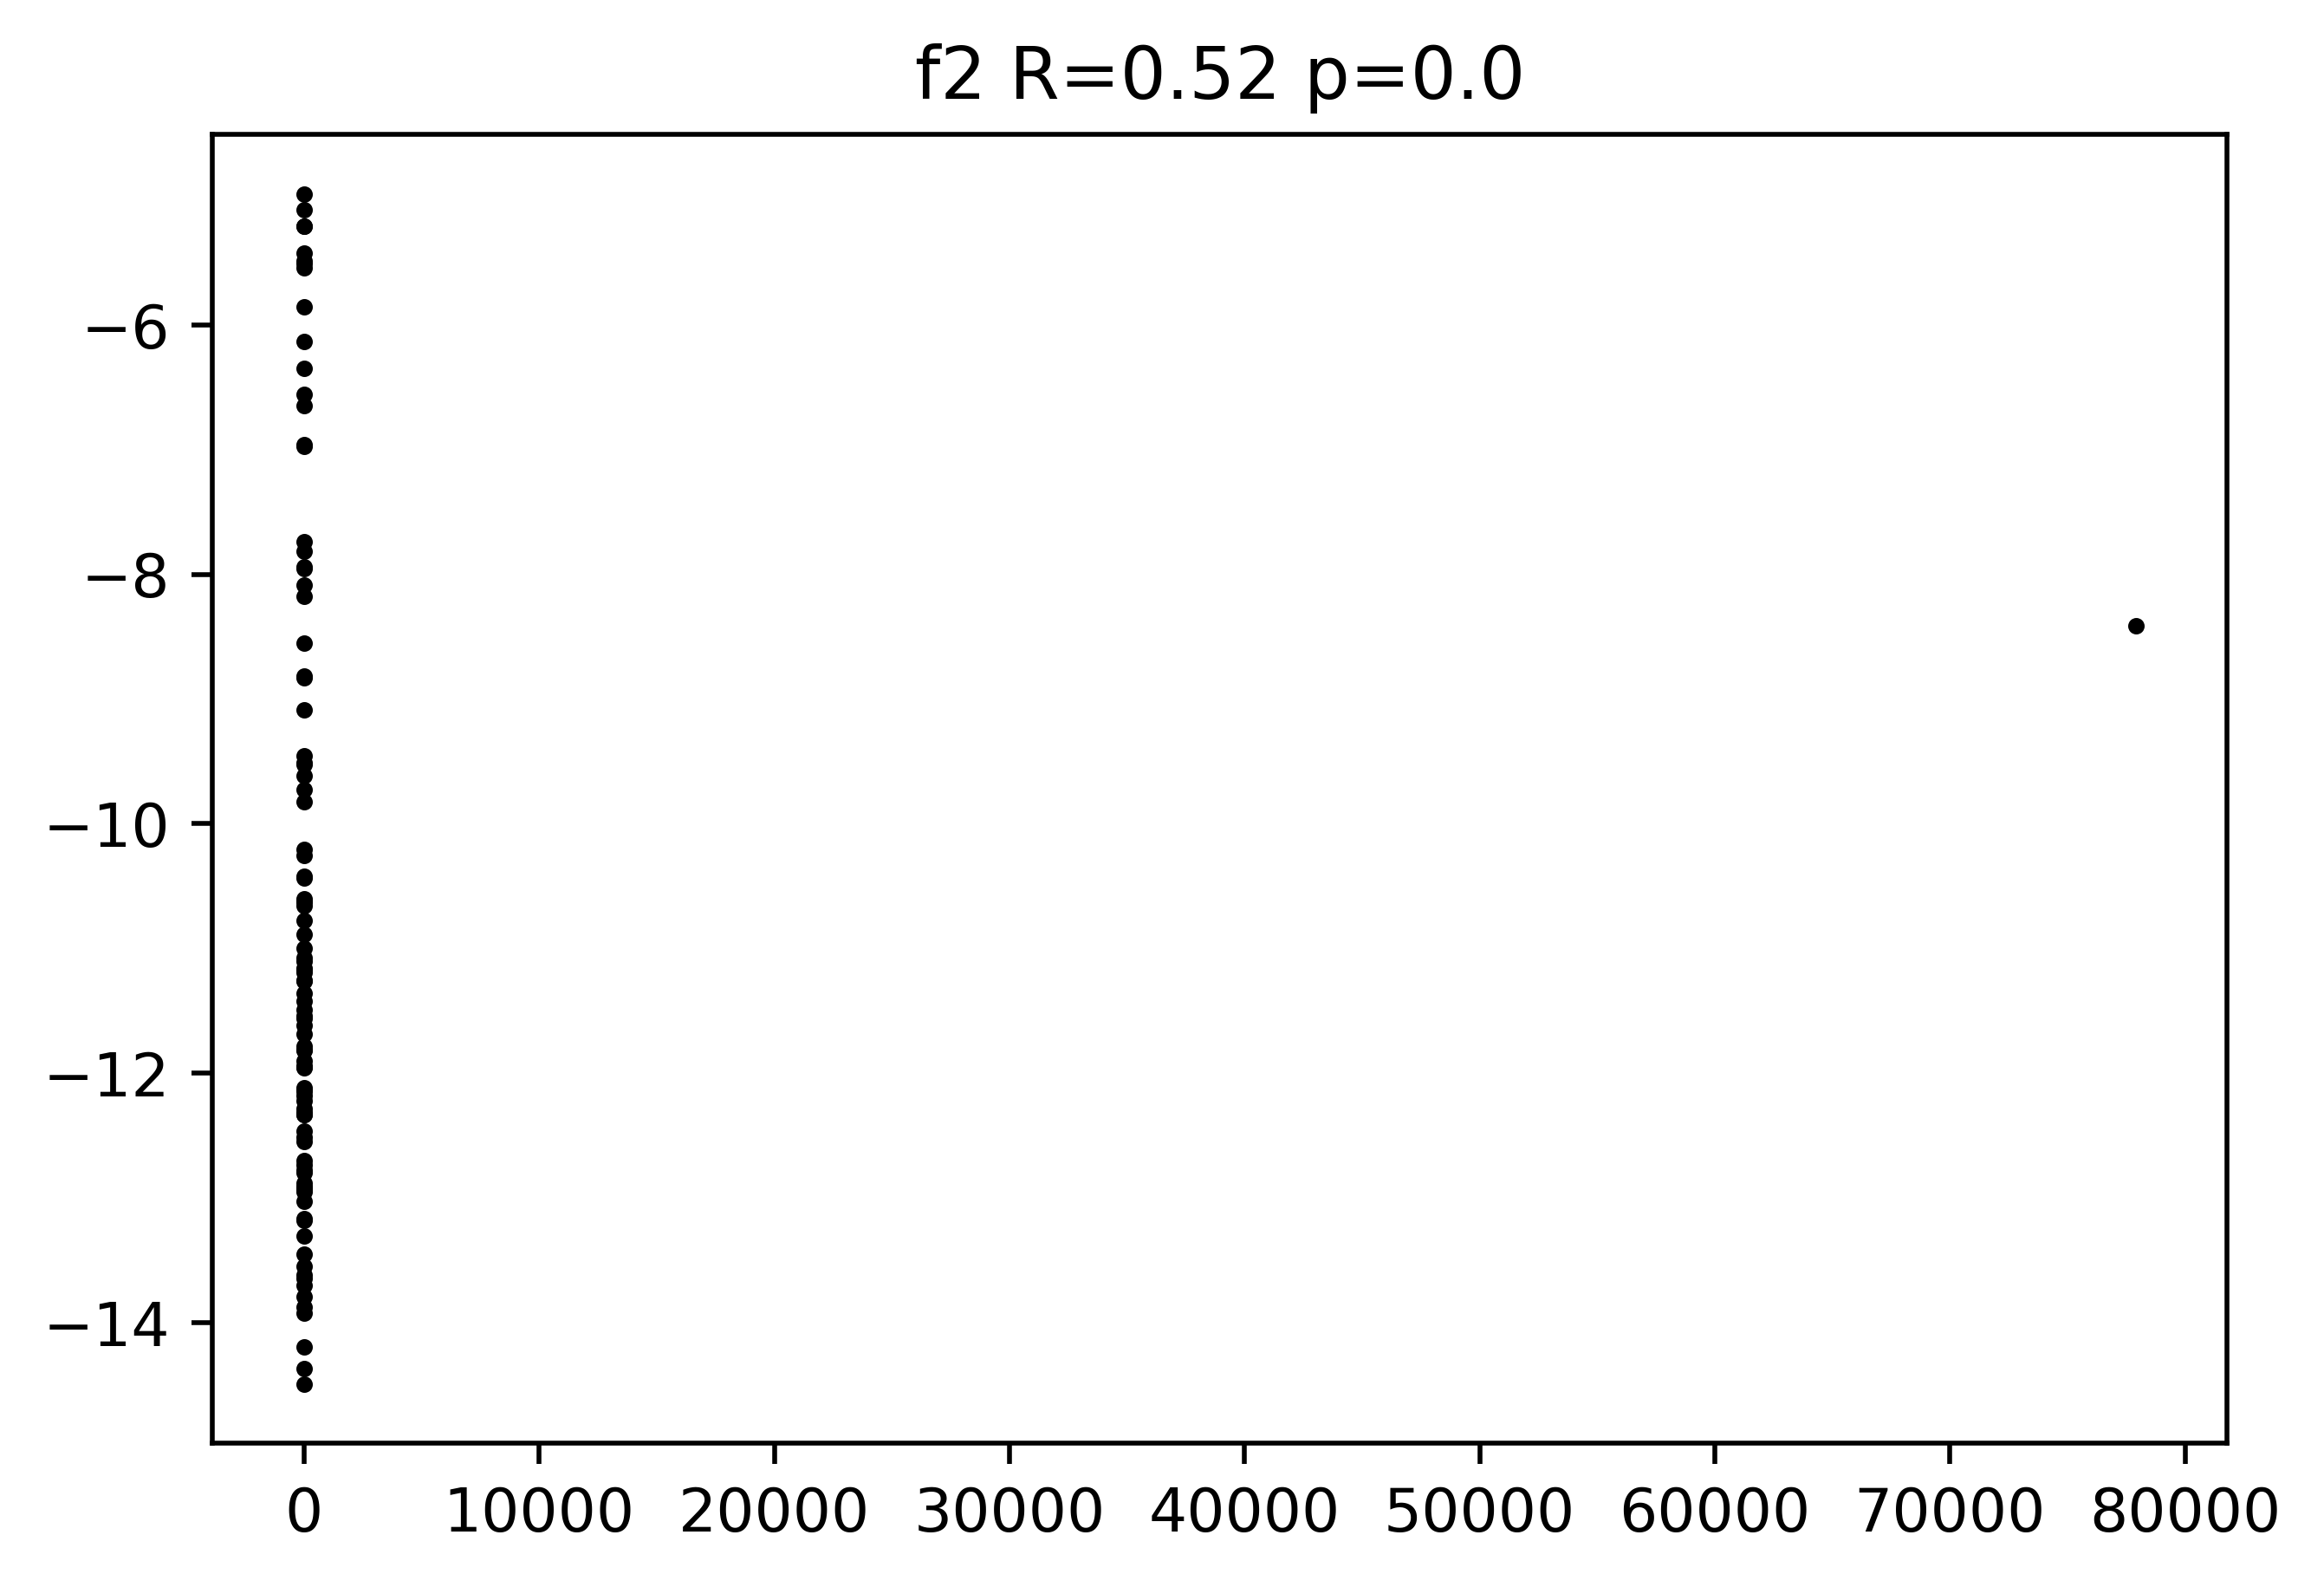

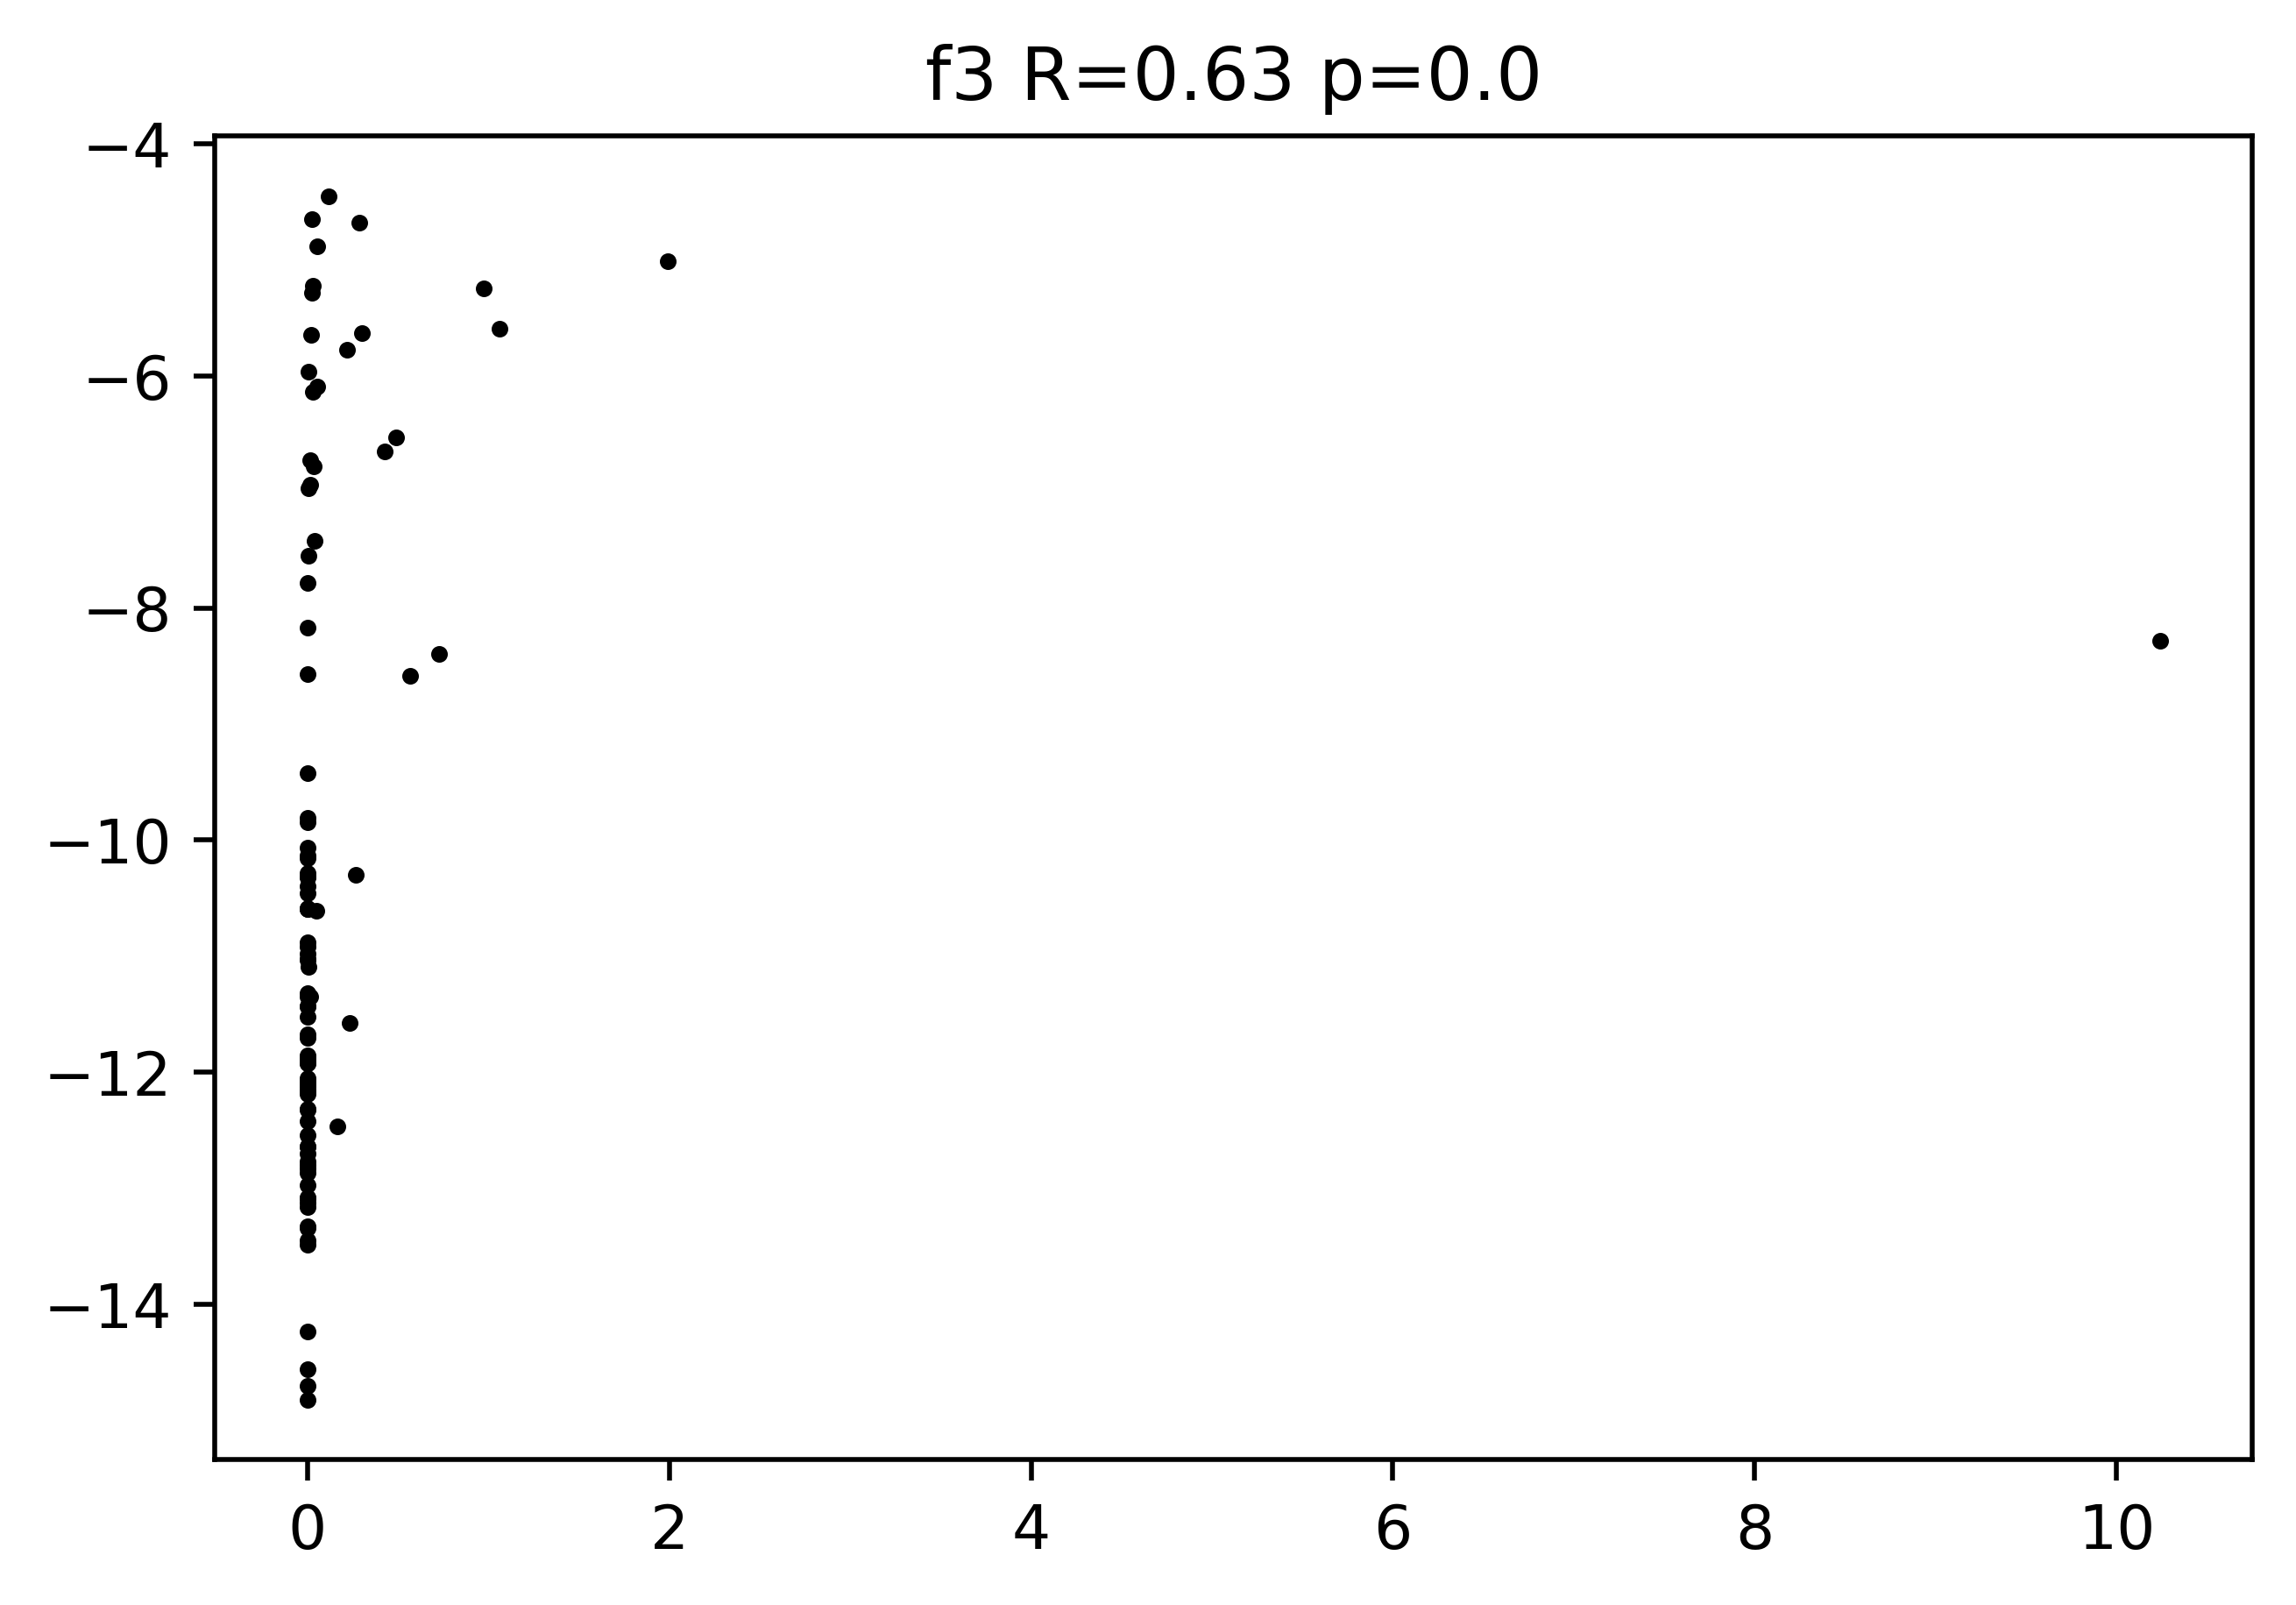

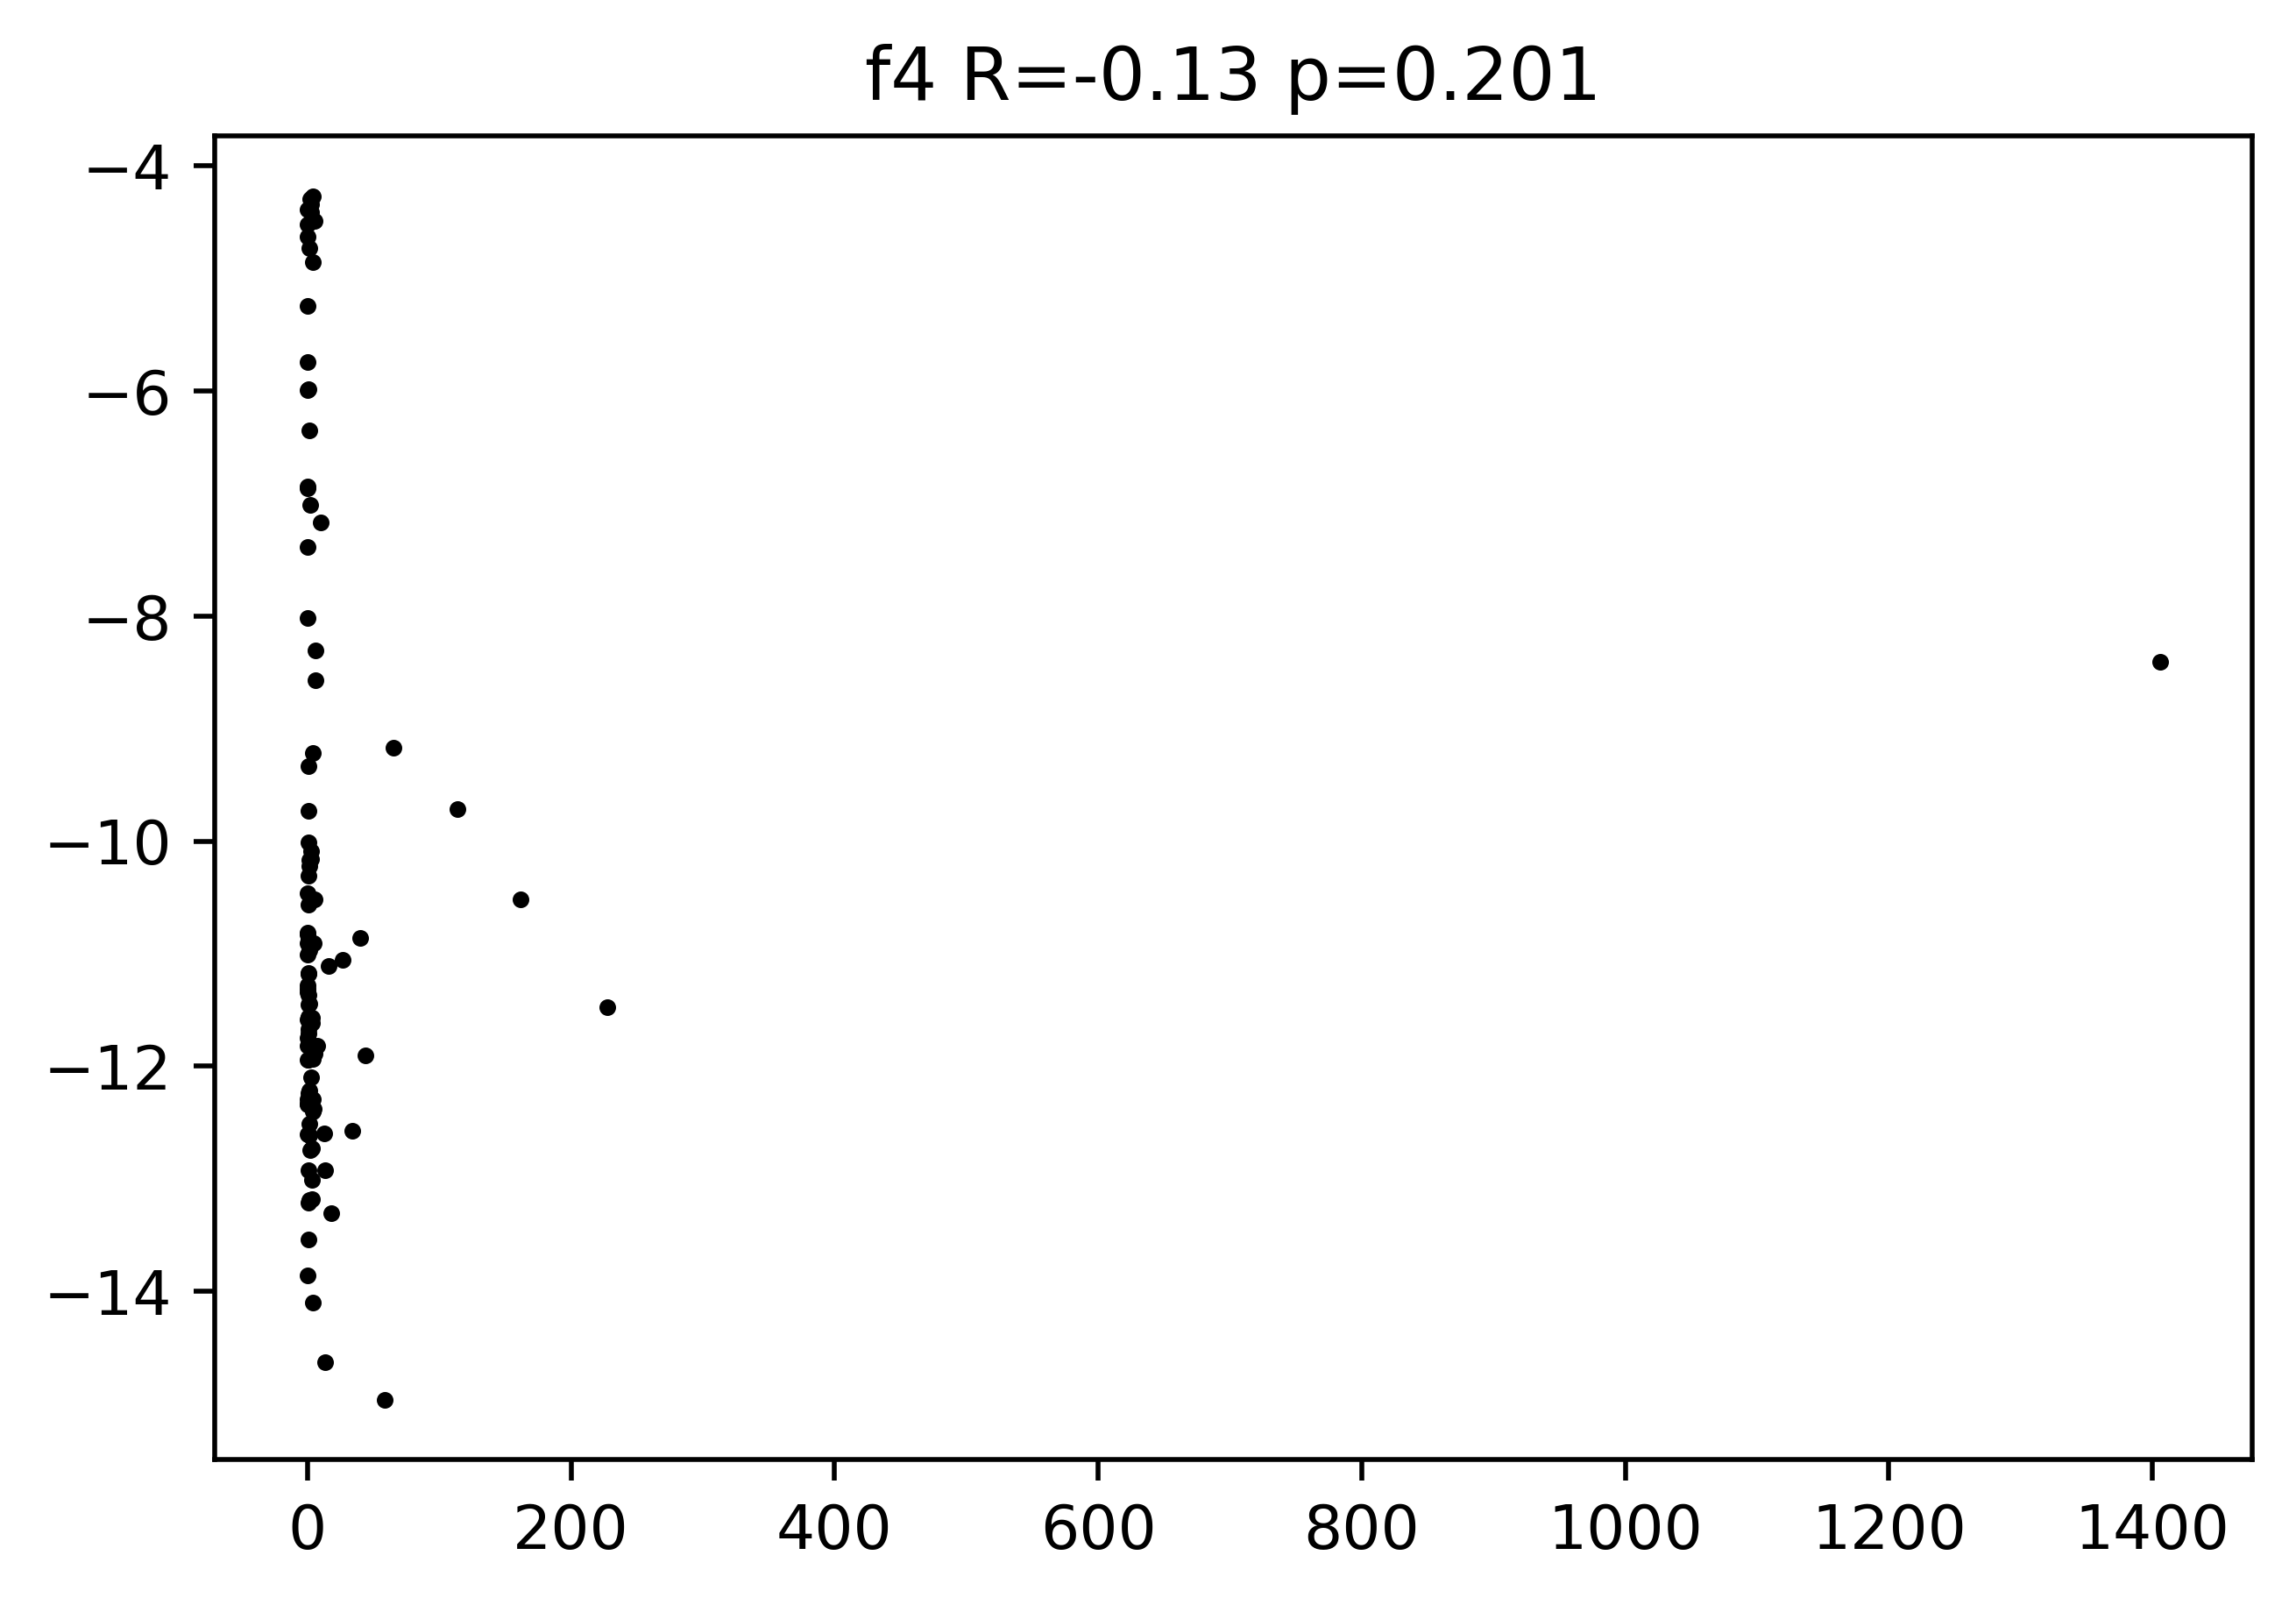

In [16]:
for x in range(pred.shape[1]):
    plt.figure()
    errs = np.abs(true[:,x]-pred[:,x])
    plt.scatter(errs,np.log10(err[:,x]),s=3,color="black")
    stat,p = stats.spearmanr(errs,err[:,x])
    plt.title("f" + str(x+1) + " R=" + str(np.round(stat,2)) + " p=" + str(np.round(p,3)))
